In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install -q transformers
    from google.colab import drive

    drive.mount('/content/drive')
    import sys

    sys.path.append('/content/drive/MyDrive/gan_bert_for_cpv')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.4 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
from transformers import logging
logging.set_verbosity_error()
import torch
from create_dataset import CreateDataset
from process_data import ProcessData
from utils import *
from torch.utils.data import DataLoader
from run_model import RunModel
from models import BertGenerator, BertDiscriminator
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [ ]:
from models import *

In [ ]:
label_column = "afdeling"
text_column = "Korte beschrijving aanbesteding"

In [ ]:
all_df = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/cleaned_dutch_ted1.csv")
vc2 = all_df[label_column].value_counts()

down_sample_vc = vc2[vc2.values <1000]
down_sample_vc = down_sample_vc[down_sample_vc.values >600]
sampled_df = all_df[all_df[label_column].isin(down_sample_vc.index)]

prd = ProcessData(sampled_df, label_column, text_column, sample_num=130, aug_limit=1000, test_per_label_num=30,
                  drop_limit=50,
                  balanced_test=True)
_,_,_, label_encoder, onehot = prd.process()

After removing duplicate sentence: 7929
After drop cpv with low observations we have : 7929
The num of class is  10
The number of total data is:  1300
Total number of test data is:  300
Total number of train data is:  1000


In [ ]:
running_device = torch.device("cuda")

In [ ]:
tbk_aug_en = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/translate_back_aug_en_100.csv")
tbk_aug_es = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/translate_back_aug_es_100.csv")
tbk_aug_sk = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/translate_back_aug_sv_100.csv")
tbk_aug_uk = pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/translate_back_aug_uk_100.csv")

train_df=pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/train_sample_100.csv")
test_df=pd.read_csv("/content/drive/MyDrive/gan_bert_for_cpv/data/test_sample_100.csv")

value_counts=train_df[label_column].value_counts()

tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
config = AutoConfig.from_pretrained("GroNLP/bert-base-dutch-cased", output_hidden_states=True)
bert = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased", config=config).to(running_device)

In [ ]:
model_runner = RunModel(running_device)
cd = CreateDataset(text_column, label_column, label_encoder, onehot, 0, running_device, max_length=120)
test_dataset = cd.create(test_df)
test_dl = DataLoader(test_dataset, shuffle=True, batch_size=20)
insuf_ds_dict = cd.create_label_dataset(train_df)
insuf_ds_list = list(insuf_ds_dict.values())

Init new bert


Getting bert hidden states from layer: 0: 100%|██████████| 100/100 [00:01<00:00, 78.65it/s]


In [ ]:
base_train_dataset = torch.utils.data.ConcatDataset(insuf_ds_list)
base_dl = DataLoader(base_train_dataset, shuffle=True, batch_size=20)
classifier = EmbeddingClassifier(prd.num_class, bert)
classifier = model_runner.train_classifier(base_dl, test_dl, classifier, lr=3e-5, n_epochs=15)

100%|██████████| 50/50 [00:21<00:00,  2.34it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.137
F1: 0.064
Precision: 0.043
Recall: 0.137
loss 2.302443790435791 0 acc:  0.13666666666666666 f1:  0.06417989473906702 precision 0.043346653346653344 recall 0.13666666666666666


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.127
F1: 0.048
Precision: 0.033
Recall: 0.127
loss 2.2952008867263793 1 acc:  0.12666666666666668 f1:  0.04819708224007902 precision 0.03264450705586409 recall 0.12666666666666665


100%|██████████| 50/50 [00:20<00:00,  2.38it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.363
F1: 0.273
Precision: 0.298
Recall: 0.363
loss 2.2451482629776 2 acc:  0.36333333333333334 f1:  0.2731210810263708 precision 0.29808617465397125 recall 0.3633333333333334


100%|██████████| 50/50 [00:20<00:00,  2.40it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.550
F1: 0.508
Precision: 0.519
Recall: 0.550
loss 1.9353291296958923 3 acc:  0.55 f1:  0.5083723745695578 precision 0.5190779459660378 recall 0.55


100%|██████████| 50/50 [00:21<00:00,  2.34it/s]


Total ACC: 0.687
F1: 0.671
Precision: 0.724
Recall: 0.687
loss 1.3835432958602905 4 acc:  0.6866666666666666 f1:  0.671191192603535 precision 0.7243170067506257 recall 0.6866666666666668


100%|██████████| 50/50 [00:21<00:00,  2.33it/s]


Total ACC: 0.727
F1: 0.721
Precision: 0.733
Recall: 0.727
loss 0.8104310470819474 5 acc:  0.7266666666666667 f1:  0.7205636755784484 precision 0.7331513277639284 recall 0.7266666666666666


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Total ACC: 0.727
F1: 0.722
Precision: 0.744
Recall: 0.727
loss 0.45093478173017504 6 acc:  0.7266666666666667 f1:  0.7216040830011204 precision 0.743623828711668 recall 0.7266666666666667


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Total ACC: 0.727
F1: 0.727
Precision: 0.752
Recall: 0.727
loss 0.24320003300905227 7 acc:  0.7266666666666667 f1:  0.7270081862289071 precision 0.752308614560956 recall 0.7266666666666668


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Total ACC: 0.757
F1: 0.757
Precision: 0.765
Recall: 0.757
loss 0.18158621206879616 8 acc:  0.7566666666666667 f1:  0.7570657860632675 precision 0.7654100645494507 recall 0.7566666666666666


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Total ACC: 0.727
F1: 0.729
Precision: 0.759
Recall: 0.727
loss 0.11853090412914753 9 acc:  0.7266666666666667 f1:  0.7293435241805396 precision 0.7590331782414212 recall 0.7266666666666667


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Total ACC: 0.737
F1: 0.736
Precision: 0.747
Recall: 0.737
loss 0.11040355917066336 10 acc:  0.7366666666666667 f1:  0.7364050078575569 precision 0.7474484913150976 recall 0.7366666666666667


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Total ACC: 0.727
F1: 0.727
Precision: 0.744
Recall: 0.727
loss 0.06952249366790056 11 acc:  0.7266666666666667 f1:  0.7272941715895874 precision 0.7438716329966331 recall 0.7266666666666667


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Total ACC: 0.753
F1: 0.749
Precision: 0.767
Recall: 0.753
loss 0.08329007105901837 12 acc:  0.7533333333333333 f1:  0.7486189748360801 precision 0.7669865266872941 recall 0.7533333333333334


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Total ACC: 0.727
F1: 0.728
Precision: 0.757
Recall: 0.727
loss 0.07116278240457177 13 acc:  0.7266666666666667 f1:  0.7276011850750392 precision 0.756614544116698 recall 0.7266666666666668


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Total ACC: 0.737
F1: 0.738
Precision: 0.774
Recall: 0.737
loss 0.06845593560487032 14 acc:  0.7366666666666667 f1:  0.7375655977013198 precision 0.7739539334787685 recall 0.7366666666666666


In [ ]:
aug_limits = decide_aug_labels(False, None, value_counts,1)
augmented_ds_lists = model_runner.augment_data(bert, aug_limits, insuf_ds_dict)

We have: 10 labels to be augmented


100%|██████████| 10/10 [09:07<00:00, 54.77s/it]


In [ ]:
gan_aug_train = torch.utils.data.ConcatDataset(insuf_ds_list+augmented_ds_lists)

In [ ]:
gan_aug_dl = DataLoader(gan_aug_train, shuffle=True, batch_size=20)

In [ ]:
classifier = EmbeddingClassifier(prd.num_class, bert)
classifier = model_runner.train_classifier(gan_aug_dl, test_dl, classifier, lr=2e-5, n_epochs=15)
predictions, labels = model_runner.predict(test_dl, classifier)
acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)

100%|██████████| 100/100 [00:43<00:00,  2.31it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.093
F1: 0.030
Precision: 0.018
Recall: 0.093
loss 2.150084490776062 0 acc:  0.09333333333333334 f1:  0.03 precision 0.018412698412698415 recall 0.09333333333333334


100%|██████████| 100/100 [00:42<00:00,  2.36it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.307
F1: 0.192
Precision: 0.164
Recall: 0.307
loss 1.8228395879268646 1 acc:  0.30666666666666664 f1:  0.192198385085654 precision 0.16373720411587483 recall 0.30666666666666664


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.580
F1: 0.529
Precision: 0.547
Recall: 0.580
loss 1.2339624112844467 2 acc:  0.58 f1:  0.5287472453740653 precision 0.547070668009485 recall 0.58


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.650
F1: 0.621
Precision: 0.611
Recall: 0.650
loss 0.7620641839504242 3 acc:  0.65 f1:  0.6213497955992816 precision 0.6111106994641478 recall 0.6499999999999999


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.657
F1: 0.626
Precision: 0.614
Recall: 0.657
loss 0.47875080406665804 4 acc:  0.6566666666666666 f1:  0.6259178374630363 precision 0.6140786226655791 recall 0.6566666666666666


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.660
F1: 0.627
Precision: 0.600
Recall: 0.660
loss 0.3500168388709426 5 acc:  0.66 f1:  0.6268741481297812 precision 0.5997755660927319 recall 0.6599999999999999


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.680
F1: 0.645
Precision: 0.627
Recall: 0.680
loss 0.2954470826871693 6 acc:  0.68 f1:  0.6451791543768777 precision 0.6271364000071924 recall 0.68


100%|██████████| 100/100 [00:42<00:00,  2.36it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.657
F1: 0.622
Precision: 0.603
Recall: 0.657
loss 0.27017702735960486 7 acc:  0.6566666666666666 f1:  0.6219253718134581 precision 0.602585226849997 recall 0.6566666666666666


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.660
F1: 0.629
Precision: 0.604
Recall: 0.660
loss 0.26033382144756617 8 acc:  0.66 f1:  0.6287486673836016 precision 0.6036207519207564 recall 0.66


100%|██████████| 100/100 [00:42<00:00,  2.36it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.677
F1: 0.646
Precision: 0.632
Recall: 0.677
loss 0.2575907177198678 9 acc:  0.6766666666666666 f1:  0.6463416766730768 precision 0.6316383409762265 recall 0.6766666666666665


100%|██████████| 100/100 [00:42<00:00,  2.37it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.680
F1: 0.647
Precision: 0.620
Recall: 0.680
loss 0.24803946145810188 10 acc:  0.68 f1:  0.6471431977773836 precision 0.6201865869880576 recall 0.6799999999999999


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.660
F1: 0.627
Precision: 0.604
Recall: 0.660
loss 0.24338537078350783 11 acc:  0.66 f1:  0.626950890917065 precision 0.6041663821283852 recall 0.66


100%|██████████| 100/100 [00:42<00:00,  2.36it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.673
F1: 0.641
Precision: 0.616
Recall: 0.673
loss 0.23986680048517883 12 acc:  0.6733333333333333 f1:  0.6414548717407628 precision 0.6163553950838434 recall 0.6733333333333333


100%|██████████| 100/100 [00:42<00:00,  2.37it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.667
F1: 0.634
Precision: 0.607
Recall: 0.667
loss 0.23808541136095301 13 acc:  0.6666666666666666 f1:  0.6339560686692488 precision 0.6073851531913573 recall 0.6666666666666667


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.670
F1: 0.637
Precision: 0.609
Recall: 0.670
loss 0.23741239747265352 14 acc:  0.67 f1:  0.636551297733343 precision 0.6086895477163667 recall 0.67
Total ACC: 0.670
F1: 0.637
Precision: 0.609
Recall: 0.670


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
tbk_aug_dataset = cd.create(tbk_aug_en)
tbk_aug_train = torch.utils.data.ConcatDataset(insuf_ds_list+[tbk_aug_dataset])
tbk_aug_dl = DataLoader(tbk_aug_train, shuffle=True, batch_size=20)

Getting bert hidden states from layer: 0: 100%|██████████| 1000/1000 [00:12<00:00, 82.86it/s]


In [ ]:
classifier = EmbeddingClassifier(prd.num_class, bert)
classifier = model_runner.train_classifier(tbk_aug_dl, test_dl, classifier, lr=3e-5, n_epochs=15)
predictions, labels = model_runner.predict(test_dl, classifier)
acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)

100%|██████████| 100/100 [00:42<00:00,  2.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.133
F1: 0.066
Precision: 0.044
Recall: 0.133
loss 2.300846059322357 0 acc:  0.13333333333333333 f1:  0.06563403008255239 precision 0.04437958455156643 recall 0.13333333333333333


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.507
F1: 0.459
Precision: 0.570
Recall: 0.507
loss 2.2140536201000214 1 acc:  0.5066666666666667 f1:  0.45929095422197264 precision 0.5701527076713969 recall 0.5066666666666666


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


Total ACC: 0.677
F1: 0.675
Precision: 0.734
Recall: 0.677
loss 1.377892946600914 2 acc:  0.6766666666666666 f1:  0.6747043526381421 precision 0.7340802492526631 recall 0.6766666666666667


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Total ACC: 0.690
F1: 0.688
Precision: 0.722
Recall: 0.690
loss 0.5413925804197788 3 acc:  0.69 f1:  0.6883655861137205 precision 0.7215115956292426 recall 0.69


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Total ACC: 0.737
F1: 0.734
Precision: 0.741
Recall: 0.737
loss 0.24055284969508647 4 acc:  0.7366666666666667 f1:  0.7343399358144529 precision 0.7412066199789017 recall 0.7366666666666666


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Total ACC: 0.693
F1: 0.691
Precision: 0.722
Recall: 0.693
loss 0.11952262971550226 5 acc:  0.6933333333333334 f1:  0.6907208092426854 precision 0.7220041159351505 recall 0.6933333333333334


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Total ACC: 0.737
F1: 0.737
Precision: 0.750
Recall: 0.737
loss 0.06257814616896212 6 acc:  0.7366666666666667 f1:  0.736603188010662 precision 0.7498301759379857 recall 0.7366666666666667


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Total ACC: 0.737
F1: 0.736
Precision: 0.756
Recall: 0.737
loss 0.06610749230720103 7 acc:  0.7366666666666667 f1:  0.7357742154226345 precision 0.7564469876969877 recall 0.7366666666666667


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


Total ACC: 0.757
F1: 0.755
Precision: 0.764
Recall: 0.757
loss 0.058637042352929714 8 acc:  0.7566666666666667 f1:  0.7551256052690478 precision 0.7643785092200652 recall 0.7566666666666666


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


Total ACC: 0.747
F1: 0.742
Precision: 0.744
Recall: 0.747
loss 0.0369360274868086 9 acc:  0.7466666666666667 f1:  0.7418499615472122 precision 0.7440068811344165 recall 0.7466666666666666


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


Total ACC: 0.767
F1: 0.763
Precision: 0.770
Recall: 0.767
loss 0.033195324037224055 10 acc:  0.7666666666666667 f1:  0.7629240197851519 precision 0.7703702709640129 recall 0.7666666666666667


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Total ACC: 0.763
F1: 0.761
Precision: 0.763
Recall: 0.763
loss 0.019050565701909362 11 acc:  0.7633333333333333 f1:  0.7610525294353405 precision 0.7633330100871815 recall 0.7633333333333333


100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


Total ACC: 0.757
F1: 0.753
Precision: 0.758
Recall: 0.757
loss 0.020292733134701847 12 acc:  0.7566666666666667 f1:  0.7533390372473134 precision 0.757804738298097 recall 0.7566666666666666


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


Total ACC: 0.760
F1: 0.757
Precision: 0.761
Recall: 0.760
loss 0.009452014439739287 13 acc:  0.76 f1:  0.756959204585794 precision 0.7608967446016266 recall 0.76


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


Total ACC: 0.767
F1: 0.764
Precision: 0.766
Recall: 0.767
loss 0.011614552733954042 14 acc:  0.7666666666666667 f1:  0.7643585229236767 precision 0.7662833644631885 recall 0.7666666666666666
Total ACC: 0.767
F1: 0.764
Precision: 0.766
Recall: 0.767


In [ ]:
classifier = EmbeddingClassifier(prd.num_class, bert)
classifier = model_runner.train_classifier(tbk_aug_dl, test_dl, classifier, lr=2e-5, n_epochs=15)
predictions, labels = model_runner.predict(test_dl, classifier)
acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)

100%|██████████| 100/100 [00:42<00:00,  2.33it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.187
F1: 0.099
Precision: 0.122
Recall: 0.187
loss 2.2980115175247193 0 acc:  0.18666666666666668 f1:  0.09868432757718472 precision 0.12227940332759608 recall 0.18666666666666668


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.527
F1: 0.449
Precision: 0.456
Recall: 0.527
loss 2.152955939769745 1 acc:  0.5266666666666666 f1:  0.44935656583002315 precision 0.45569183211424596 recall 0.5266666666666666


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.597
F1: 0.526
Precision: 0.477
Recall: 0.597
loss 1.5329991036653519 2 acc:  0.5966666666666667 f1:  0.5256992760417418 precision 0.47654936226661054 recall 0.5966666666666667


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.653
F1: 0.596
Precision: 0.637
Recall: 0.653
loss 0.9613004279136658 3 acc:  0.6533333333333333 f1:  0.5957195036943973 precision 0.6371600763067322 recall 0.6533333333333334


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.653
F1: 0.634
Precision: 0.644
Recall: 0.653
loss 0.6040469105541706 4 acc:  0.6533333333333333 f1:  0.633990212899169 precision 0.6436172935965812 recall 0.6533333333333333


 17%|█▋        | 17/100 [00:07<00:35,  2.33it/s]

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
aug_limits = decide_aug_labels(True, 400, value_counts,0.5)
augmented_ds_lists = model_runner.augment_data(bert, aug_limits, insuf_ds_dict)
gan_aug_train = torch.utils.data.ConcatDataset(insuf_ds_list+augmented_ds_lists)
gan_aug_dl = DataLoader(gan_aug_train, shuffle=True, batch_size=20)

We have: 9 labels to be augmented


100%|██████████| 9/9 [07:29<00:00, 49.93s/it]


In [ ]:
classifier = HiddenClassifier3(prd.num_class, bert)
classifier = model_runner.train_classifier(gan_aug_dl, test_dl, classifier, lr=2e-5, n_epochs=15)

100%|██████████| 176/176 [00:52<00:00,  3.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.115
F1: 0.029
Precision: 0.124
Recall: 0.115
loss 1.554362605241212 0 acc:  0.11481481481481481 f1:  0.02946500281703648 precision 0.12350268484097479 recall 0.11481481481481483


100%|██████████| 176/176 [00:52<00:00,  3.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.559
F1: 0.502
Precision: 0.494
Recall: 0.559
loss 0.614086395806887 1 acc:  0.5592592592592592 f1:  0.5023871297140222 precision 0.49429098107587804 recall 0.5592592592592593


100%|██████████| 176/176 [00:52<00:00,  3.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.556
Precision: 0.584
Recall: 0.611
loss 0.245188450419598 2 acc:  0.6111111111111112 f1:  0.5555627934287806 precision 0.5842354117418055 recall 0.6111111111111112


100%|██████████| 176/176 [00:52<00:00,  3.35it/s]


Total ACC: 0.659
F1: 0.632
Precision: 0.687
Recall: 0.659
loss 0.11363130709452723 3 acc:  0.6592592592592592 f1:  0.6318116267708828 precision 0.6865953266650838 recall 0.6592592592592594


100%|██████████| 176/176 [00:52<00:00,  3.35it/s]


Total ACC: 0.700
F1: 0.687
Precision: 0.730
Recall: 0.700
loss 0.049575793167936026 4 acc:  0.7 f1:  0.6874660989287373 precision 0.730467996054091 recall 0.7


100%|██████████| 176/176 [00:52<00:00,  3.35it/s]


Total ACC: 0.707
F1: 0.696
Precision: 0.708
Recall: 0.707
loss 0.028806526195363735 5 acc:  0.7074074074074074 f1:  0.6958749685776239 precision 0.7082214558237949 recall 0.7074074074074074


100%|██████████| 176/176 [00:52<00:00,  3.35it/s]


Total ACC: 0.726
F1: 0.708
Precision: 0.738
Recall: 0.726
loss 0.026026282837847248 6 acc:  0.725925925925926 f1:  0.7079177166214301 precision 0.7382563499774631 recall 0.7259259259259259


100%|██████████| 176/176 [00:52<00:00,  3.35it/s]


Total ACC: 0.719
F1: 0.703
Precision: 0.716
Recall: 0.719
loss 0.01183410107808992 7 acc:  0.7185185185185186 f1:  0.7026732820118299 precision 0.7163874438703935 recall 0.7185185185185186


100%|██████████| 176/176 [00:52<00:00,  3.35it/s]


Total ACC: 0.711
F1: 0.703
Precision: 0.730
Recall: 0.711
loss 0.0074815388764942654 8 acc:  0.7111111111111111 f1:  0.7029949097977711 precision 0.7304256079374674 recall 0.711111111111111


100%|██████████| 176/176 [00:52<00:00,  3.35it/s]


Total ACC: 0.730
F1: 0.711
Precision: 0.768
Recall: 0.730
loss 0.003985971146903466 9 acc:  0.7296296296296296 f1:  0.7105837883133871 precision 0.7683624240832478 recall 0.7296296296296296


100%|██████████| 176/176 [00:52<00:00,  3.35it/s]


Total ACC: 0.719
F1: 0.703
Precision: 0.756
Recall: 0.719
loss 0.006746575065666217 10 acc:  0.7185185185185186 f1:  0.702609158020521 precision 0.756331062933241 recall 0.7185185185185186


100%|██████████| 176/176 [00:52<00:00,  3.35it/s]


Total ACC: 0.726
F1: 0.709
Precision: 0.760
Recall: 0.726
loss 0.0023516448100880634 11 acc:  0.725925925925926 f1:  0.7087855264157628 precision 0.7596820940036716 recall 0.7259259259259259


100%|██████████| 176/176 [00:52<00:00,  3.35it/s]


Total ACC: 0.719
F1: 0.704
Precision: 0.735
Recall: 0.719
loss 0.00168679657872417 12 acc:  0.7185185185185186 f1:  0.7038150974266281 precision 0.7349718080175008 recall 0.7185185185185186


100%|██████████| 176/176 [00:52<00:00,  3.34it/s]


Total ACC: 0.715
F1: 0.691
Precision: 0.753
Recall: 0.715
loss 0.001346805312178648 13 acc:  0.7148148148148148 f1:  0.6913899754082325 precision 0.7534912393608046 recall 0.7148148148148148


100%|██████████| 176/176 [00:52<00:00,  3.34it/s]


Total ACC: 0.715
F1: 0.692
Precision: 0.752
Recall: 0.715
loss 0.0010904439107186838 14 acc:  0.7148148148148148 f1:  0.692237654741845 precision 0.7521606942775851 recall 0.7148148148148148


In [ ]:
sampled_df=translate_back.groupby(label_column, sort=False).sample(frac=float(1/8))
sub_sample=sampled_df.groupby(label_column, sort=False).sample(frac=float(1/2))
half_augmented_ds_lists=[]
for dataset in augmented_ds_lists:
    evens = list(range(0, len(dataset), 2))
    subdataset = torch.utils.data.Subset(dataset, evens)
    half_augmented_ds_lists.append(subdataset)
tbk_aug_dataset = cd.create(sampled_df)
sub_tbk_aug=cd.create(sub_sample)
tbk_aug_train = torch.utils.data.ConcatDataset(insuf_ds_list+[tbk_aug_dataset])
print(len(tbk_aug_train))
gan_aug_train = torch.utils.data.ConcatDataset(insuf_ds_list+augmented_ds_lists)
print(len(gan_aug_train))
hybrid_train = torch.utils.data.ConcatDataset(insuf_ds_list+half_augmented_ds_lists+[sub_tbk_aug])
print(len(hybrid_train))
tbk_aug_dl = DataLoader(tbk_aug_train, shuffle=True, batch_size=40)

gan_aug_dl = DataLoader(gan_aug_train, shuffle=True, batch_size=40)

hybrid_dl = DataLoader(hybrid_train, shuffle=True, batch_size=40)

We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 290/290 [00:03<00:00, 80.32it/s]


1740
1680
1710


In [ ]:
  classifier = HiddenClassifier3(prd.num_class, bert)
  classifier = model_runner.train_classifier(tbk_aug_dl, test_dl, classifier, lr=2e-5, n_epochs=15)
  predictions, labels = model_runner.predict(test_dl, classifier)
  acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)

100%|██████████| 44/44 [00:25<00:00,  1.73it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.130
F1: 0.048
Precision: 0.030
Recall: 0.130
loss 2.184062448414889 0 acc:  0.12962962962962962 f1:  0.048246697970727954 precision 0.030164651402109593 recall 0.12962962962962962


100%|██████████| 44/44 [00:25<00:00,  1.74it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.111
F1: 0.022
Precision: 0.012
Recall: 0.111
loss 2.1544922590255737 1 acc:  0.1111111111111111 f1:  0.02222222222222222 precision 0.012345679012345678 recall 0.1111111111111111


100%|██████████| 44/44 [00:25<00:00,  1.74it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.219
F1: 0.150
Precision: 0.158
Recall: 0.219
loss 2.088384441354058 2 acc:  0.21851851851851853 f1:  0.14956312814526565 precision 0.15793313627866376 recall 0.21851851851851853


100%|██████████| 44/44 [00:25<00:00,  1.74it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.322
F1: 0.205
Precision: 0.281
Recall: 0.322
loss 1.8705713938583026 3 acc:  0.32222222222222224 f1:  0.20549909924486656 precision 0.281006581170687 recall 0.32222222222222224


100%|██████████| 44/44 [00:25<00:00,  1.73it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.507
F1: 0.412
Precision: 0.358
Recall: 0.507
loss 1.4614281844009052 4 acc:  0.5074074074074074 f1:  0.4119100811602614 precision 0.35776192079096825 recall 0.5074074074074074


100%|██████████| 44/44 [00:25<00:00,  1.73it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.567
F1: 0.476
Precision: 0.496
Recall: 0.567
loss 1.0250042135065252 5 acc:  0.5666666666666667 f1:  0.47559450388928176 precision 0.49601210540016677 recall 0.5666666666666668


100%|██████████| 44/44 [00:25<00:00,  1.73it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.578
F1: 0.496
Precision: 0.459
Recall: 0.578
loss 0.7079371322285045 6 acc:  0.5777777777777777 f1:  0.4956692561599118 precision 0.45882999829552734 recall 0.5777777777777778


100%|██████████| 44/44 [00:25<00:00,  1.73it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.600
F1: 0.516
Precision: 0.473
Recall: 0.600
loss 0.5341846787116744 7 acc:  0.6 f1:  0.5161767484584661 precision 0.4727888925234693 recall 0.6000000000000001


100%|██████████| 44/44 [00:25<00:00,  1.73it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.622
F1: 0.547
Precision: 0.494
Recall: 0.622
loss 0.4208392145281488 8 acc:  0.6222222222222222 f1:  0.5474908575145221 precision 0.49427520077674875 recall 0.6222222222222222


100%|██████████| 44/44 [00:25<00:00,  1.73it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.536
Precision: 0.478
Recall: 0.615
loss 0.3343042968349023 9 acc:  0.6148148148148148 f1:  0.5361704321791314 precision 0.4783811846423541 recall 0.6148148148148148


100%|██████████| 44/44 [00:25<00:00,  1.73it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.540
Precision: 0.491
Recall: 0.611
loss 0.27066361176019366 10 acc:  0.6111111111111112 f1:  0.5397932160508196 precision 0.49074926718654943 recall 0.6111111111111112


100%|██████████| 44/44 [00:25<00:00,  1.74it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.622
F1: 0.561
Precision: 0.548
Recall: 0.622
loss 0.21257101439616896 11 acc:  0.6222222222222222 f1:  0.561016133448189 precision 0.5484502608629926 recall 0.6222222222222222


100%|██████████| 44/44 [00:25<00:00,  1.74it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.648
F1: 0.600
Precision: 0.591
Recall: 0.648
loss 0.17062295744703573 12 acc:  0.6481481481481481 f1:  0.6000498787594389 precision 0.5909645593000321 recall 0.6481481481481481


100%|██████████| 44/44 [00:25<00:00,  1.73it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.659
F1: 0.618
Precision: 0.599
Recall: 0.659
loss 0.14528967918489466 13 acc:  0.6592592592592592 f1:  0.6177330989462293 precision 0.5987527312944514 recall 0.6592592592592593


100%|██████████| 44/44 [00:25<00:00,  1.73it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.674
F1: 0.631
Precision: 0.614
Recall: 0.674
loss 0.11972161746499213 14 acc:  0.674074074074074 f1:  0.6308856029673625 precision 0.6142464838065028 recall 0.674074074074074
Total ACC: 0.674
F1: 0.631
Precision: 0.614
Recall: 0.674


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
classifier = model_runner.train_classifier(tbk_aug_dl, test_dl, classifier, lr=2e-5, n_epochs=2)

100%|██████████| 44/44 [00:25<00:00,  1.75it/s]


Total ACC: 0.681
F1: 0.675
Precision: 0.679
Recall: 0.681
loss 0.027978637737264347 0 acc:  0.6814814814814815 f1:  0.674547265923752 precision 0.6786425109037894 recall 0.6814814814814815


100%|██████████| 44/44 [00:26<00:00,  1.69it/s]


Total ACC: 0.641
F1: 0.616
Precision: 0.643
Recall: 0.641
loss 0.02868590229296718 1 acc:  0.6407407407407407 f1:  0.6163369361388961 precision 0.6430265217450573 recall 0.6407407407407406


In [ ]:
  classifier = HiddenClassifier3(prd.num_class, bert)
  classifier = model_runner.train_classifier(gan_aug_dl, test_dl, classifier, lr=3e-5, n_epochs=5)

100%|██████████| 42/42 [00:24<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.115
F1: 0.029
Precision: 0.068
Recall: 0.115
loss 2.0937658065841314 0 acc:  0.11481481481481481 f1:  0.029315809097688297 precision 0.06799336650082918 recall 0.11481481481481483


100%|██████████| 42/42 [00:24<00:00,  1.70it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.296
F1: 0.175
Precision: 0.255
Recall: 0.296
loss 1.835870589528765 1 acc:  0.2962962962962963 f1:  0.17494630506812114 precision 0.2548276719666504 recall 0.29629629629629634


100%|██████████| 42/42 [00:24<00:00,  1.73it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.452
F1: 0.334
Precision: 0.275
Recall: 0.452
loss 1.3547717957269578 2 acc:  0.45185185185185184 f1:  0.33440695887953276 precision 0.2753540680328046 recall 0.45185185185185184


100%|██████████| 42/42 [00:24<00:00,  1.74it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.548
F1: 0.471
Precision: 0.443
Recall: 0.548
loss 0.9739296379543486 3 acc:  0.5481481481481482 f1:  0.47125077336008736 precision 0.4426572955628646 recall 0.5481481481481482


100%|██████████| 42/42 [00:24<00:00,  1.73it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.552
F1: 0.466
Precision: 0.428
Recall: 0.552
loss 0.7612795716240293 4 acc:  0.5518518518518518 f1:  0.46604831575898487 precision 0.4281358580510716 recall 0.5518518518518518
Total ACC: 0.552
F1: 0.466
Precision: 0.428
Recall: 0.552


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
classifier = model_runner.train_classifier(gan_aug_dl, test_dl, classifier, lr=2e-5, n_epochs=5)

100%|██████████| 42/42 [00:24<00:00,  1.71it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.538
Precision: 0.482
Recall: 0.615
loss 0.6332205413352876 0 acc:  0.6148148148148148 f1:  0.538317454994142 precision 0.48208323313361173 recall 0.6148148148148148


100%|██████████| 42/42 [00:24<00:00,  1.71it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.535
Precision: 0.497
Recall: 0.611
loss 0.49970149000485736 1 acc:  0.6111111111111112 f1:  0.5347848157737835 precision 0.4971374969740983 recall 0.6111111111111112


100%|██████████| 42/42 [00:24<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.600
F1: 0.530
Precision: 0.485
Recall: 0.600
loss 0.31034628443774726 2 acc:  0.6 f1:  0.5297895427874959 precision 0.4846265841705878 recall 0.6000000000000001


100%|██████████| 42/42 [00:24<00:00,  1.73it/s]


Total ACC: 0.637
F1: 0.582
Precision: 0.673
Recall: 0.637
loss 0.20609652827538194 3 acc:  0.6370370370370371 f1:  0.5819647892943454 precision 0.6728233435924921 recall 0.6370370370370371


100%|██████████| 42/42 [00:24<00:00,  1.72it/s]


Total ACC: 0.644
F1: 0.599
Precision: 0.583
Recall: 0.644
loss 0.14976878805706897 4 acc:  0.6444444444444445 f1:  0.5988588167743951 precision 0.5828880458379166 recall 0.6444444444444445


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
classifier = model_runner.train_classifier(gan_aug_dl, test_dl, classifier, lr=2e-5, n_epochs=5)

100%|██████████| 42/42 [00:24<00:00,  1.73it/s]


Total ACC: 0.637
F1: 0.578
Precision: 0.608
Recall: 0.637
loss 0.12458845192477816 0 acc:  0.6370370370370371 f1:  0.5782529731508458 precision 0.6081738814688517 recall 0.6370370370370371


100%|██████████| 42/42 [00:25<00:00,  1.67it/s]


Total ACC: 0.663
F1: 0.639
Precision: 0.687
Recall: 0.663
loss 0.08880145524051927 1 acc:  0.662962962962963 f1:  0.63894130484307 precision 0.6867260677605506 recall 0.662962962962963


100%|██████████| 42/42 [00:24<00:00,  1.74it/s]


Total ACC: 0.700
F1: 0.675
Precision: 0.685
Recall: 0.700
loss 0.07513241534165684 2 acc:  0.7 f1:  0.6746241555231896 precision 0.6851195546312034 recall 0.6999999999999998


100%|██████████| 42/42 [00:24<00:00,  1.74it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.685
F1: 0.641
Precision: 0.607
Recall: 0.685
loss 0.06174673879563454 3 acc:  0.6851851851851852 f1:  0.6409671853764146 precision 0.6072873905897641 recall 0.6851851851851851


100%|██████████| 42/42 [00:24<00:00,  1.72it/s]


Total ACC: 0.693
F1: 0.662
Precision: 0.697
Recall: 0.693
loss 0.06129432490672029 4 acc:  0.6925925925925925 f1:  0.6621297238208754 precision 0.6971847456017652 recall 0.6925925925925926


In [ ]:
  classifier = HiddenClassifier3(prd.num_class, bert)
  classifier = model_runner.train_classifier(hybrid_dl, test_dl, classifier, lr=3e-5, n_epochs=8)

100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.111
F1: 0.022
Precision: 0.012
Recall: 0.111
loss 2.1340658997380455 0 acc:  0.1111111111111111 f1:  0.02222222222222222 precision 0.012345679012345678 recall 0.1111111111111111


100%|██████████| 43/43 [00:25<00:00,  1.67it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.333
F1: 0.222
Precision: 0.187
Recall: 0.333
loss 1.9273933338564495 1 acc:  0.3333333333333333 f1:  0.2215165985194553 precision 0.18737440249731735 recall 0.3333333333333333


100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.459
F1: 0.362
Precision: 0.395
Recall: 0.459
loss 1.3809720083724621 2 acc:  0.45925925925925926 f1:  0.3620658663355604 precision 0.39451468964479186 recall 0.4592592592592592


100%|██████████| 43/43 [00:24<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.570
F1: 0.458
Precision: 0.387
Recall: 0.570
loss 0.9300145534581916 3 acc:  0.5703703703703704 f1:  0.4577242348126094 precision 0.38715902445410644 recall 0.5703703703703704


100%|██████████| 43/43 [00:25<00:00,  1.71it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.574
F1: 0.470
Precision: 0.407
Recall: 0.574
loss 0.6628488617580991 4 acc:  0.5740740740740741 f1:  0.46969846780753344 precision 0.4068166748820086 recall 0.5740740740740741


100%|██████████| 43/43 [00:24<00:00,  1.72it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.539
Precision: 0.482
Recall: 0.615
loss 0.46969320053278013 5 acc:  0.6148148148148148 f1:  0.5394406477988567 precision 0.48179357302164316 recall 0.6148148148148148


100%|██████████| 43/43 [00:24<00:00,  1.74it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.546
Precision: 0.592
Recall: 0.619
loss 0.3187721246896788 6 acc:  0.6185185185185185 f1:  0.5461970929503271 precision 0.5924549900040096 recall 0.6185185185185186


100%|██████████| 43/43 [00:24<00:00,  1.73it/s]


Total ACC: 0.637
F1: 0.576
Precision: 0.644
Recall: 0.637
loss 0.21047137591034867 7 acc:  0.6370370370370371 f1:  0.5763241945463142 precision 0.6441770842439607 recall 0.6370370370370372


In [ ]:
  classifier = model_runner.train_classifier(hybrid_dl, test_dl, classifier, lr=3e-5, n_epochs=5)

100%|██████████| 43/43 [00:24<00:00,  1.74it/s]


Total ACC: 0.696
F1: 0.685
Precision: 0.699
Recall: 0.696
loss 0.1416103624153969 0 acc:  0.6962962962962963 f1:  0.6853844776371666 precision 0.6994704239716973 recall 0.6962962962962962


100%|██████████| 43/43 [00:25<00:00,  1.68it/s]


Total ACC: 0.693
F1: 0.671
Precision: 0.691
Recall: 0.693
loss 0.1083810004557288 1 acc:  0.6925925925925925 f1:  0.6708322281603133 precision 0.6905751044795769 recall 0.6925925925925926


100%|██████████| 43/43 [00:24<00:00,  1.74it/s]


Total ACC: 0.689
F1: 0.668
Precision: 0.692
Recall: 0.689
loss 0.07198937410532041 2 acc:  0.6888888888888889 f1:  0.6680633655667148 precision 0.6922099343151975 recall 0.6888888888888888


100%|██████████| 43/43 [00:24<00:00,  1.74it/s]


Total ACC: 0.674
F1: 0.647
Precision: 0.667
Recall: 0.674
loss 0.07494232253453066 3 acc:  0.674074074074074 f1:  0.646655617543023 precision 0.6671851910717771 recall 0.674074074074074


100%|██████████| 43/43 [00:25<00:00,  1.72it/s]


Total ACC: 0.667
F1: 0.638
Precision: 0.663
Recall: 0.667
loss 0.07427339537372422 4 acc:  0.6666666666666666 f1:  0.6375344171777321 precision 0.6625268953403929 recall 0.6666666666666666


In [ ]:
tbk_acc,gan_acc,hybrid_acc = [],[],[]
tbk_f1,gan_f1,hybrid_f1 = [],[],[]
tbk_recall,gan_recall,hybrid_recall = [],[],[]
tbk_precision,gan_precision,hybrid_precision = [],[],[]
tbk_all,gan_all,hybrid_all = [],[],[]
for i in range(1,11):
  sampled_df=translate_back.groupby(label_column, sort=False).sample(frac=float(i/16))
  sub_sample=sampled_df.groupby(label_column, sort=False).sample(frac=float(1/2))
  aug_limits = decide_aug_labels(False, None, value_counts,0.2*i)
  augmented_ds_lists = model_runner.augment_data(bert, aug_limits, insuf_ds_dict)
  half_augmented_ds_lists=[]
  for dataset in augmented_ds_lists:
      evens = list(range(0, len(dataset), 2))
      subdataset = torch.utils.data.Subset(dataset, evens)
      half_augmented_ds_lists.append(subdataset)
  tbk_aug_dataset = cd.create(sampled_df)
  sub_tbk_aug=cd.create(sub_sample)
  tbk_aug_train = torch.utils.data.ConcatDataset(insuf_ds_list+[tbk_aug_dataset])
  print(len(tbk_aug_train))
  gan_aug_train = torch.utils.data.ConcatDataset(insuf_ds_list+augmented_ds_lists)
  print(len(gan_aug_train))
  hybrid_train = torch.utils.data.ConcatDataset(insuf_ds_list+half_augmented_ds_lists+[sub_tbk_aug])
  print(len(hybrid_train))
  tbk_aug_dl = DataLoader(tbk_aug_train, shuffle=True, batch_size=40)

  gan_aug_dl = DataLoader(gan_aug_train, shuffle=True, batch_size=40)

  hybrid_dl = DataLoader(hybrid_train, shuffle=True, batch_size=40)
  print("-----------------------------tbk-------------------------------",i)
  classifier = HiddenClassifier3(prd.num_class, bert)
  classifier = model_runner.train_classifier(tbk_aug_dl, test_dl, classifier, lr=2e-5, n_epochs=15)
  predictions, labels = model_runner.predict(test_dl, classifier)
  acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)
  tbk_acc.append(acc)
  tbk_f1.append(f1)
  tbk_recall.append(recall)
  tbk_precision.append(precision)
  tbk_all.append(label_f1)
  print("-----------------------------tbk-------------------------------",i)
  print("-----------------------------gan-------------------------------",i)
  classifier = HiddenClassifier3(prd.num_class, bert)
  classifier = model_runner.train_classifier(gan_aug_dl, test_dl, classifier, lr=2e-5, n_epochs=15)
  predictions, labels = model_runner.predict(test_dl, classifier)
  acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)
  gan_acc.append(acc)
  gan_f1.append(f1)
  gan_recall.append(recall)
  gan_precision.append(precision)
  gan_all.append(label_f1)
  print("-----------------------------gan-------------------------------",i)
  print("-----------------------------h-------------------------------",i)
  classifier = HiddenClassifier3(prd.num_class, bert)
  classifier = model_runner.train_classifier(hybrid_dl, test_dl, classifier, lr=2e-5, n_epochs=15)
  predictions, labels = model_runner.predict(test_dl, classifier)
  acc, f1, precision, recall, label_f1 = evaluate(labels, predictions)
  print("-----------------------------h-------------------------------",i)
  hybrid_acc.append(acc)
  hybrid_f1.append(f1)
  hybrid_recall.append(recall)
  hybrid_precision.append(precision)
  hybrid_all.append(label_f1)


We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 146/146 [00:01<00:00, 77.88it/s]


1450
1380
1416
-----------------------------tbk------------------------------- 1


100%|██████████| 37/37 [00:20<00:00,  1.79it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.111
F1: 0.022
Precision: 0.012
Recall: 0.111
loss 2.1882615476041227 0 acc:  0.1111111111111111 f1:  0.02222222222222222 precision 0.012345679012345678 recall 0.1111111111111111


100%|██████████| 37/37 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.111
F1: 0.022
Precision: 0.012
Recall: 0.111
loss 2.1668749951027535 1 acc:  0.1111111111111111 f1:  0.02222222222222222 precision 0.012345679012345678 recall 0.1111111111111111


100%|██████████| 37/37 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.248
F1: 0.159
Precision: 0.249
Recall: 0.248
loss 2.120147608421944 2 acc:  0.24814814814814815 f1:  0.15870114709010574 precision 0.24881038501728156 recall 0.24814814814814815


100%|██████████| 37/37 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.363
F1: 0.256
Precision: 0.223
Recall: 0.363
loss 1.897674924618489 3 acc:  0.362962962962963 f1:  0.2560745236032592 precision 0.22259911574980068 recall 0.36296296296296293


100%|██████████| 37/37 [00:20<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.444
F1: 0.334
Precision: 0.370
Recall: 0.444
loss 1.4929504813374699 4 acc:  0.4444444444444444 f1:  0.33365867361471535 precision 0.37042530902996024 recall 0.4444444444444444


100%|██████████| 37/37 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.530
F1: 0.429
Precision: 0.374
Recall: 0.530
loss 1.0635041256208677 5 acc:  0.5296296296296297 f1:  0.4291219738529982 precision 0.3739995097849504 recall 0.5296296296296297


100%|██████████| 37/37 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.589
F1: 0.512
Precision: 0.479
Recall: 0.589
loss 0.7425556400337735 6 acc:  0.5888888888888889 f1:  0.5122453532906011 precision 0.47882269630635643 recall 0.5888888888888889


100%|██████████| 37/37 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.581
F1: 0.508
Precision: 0.455
Recall: 0.581
loss 0.5197847018370757 7 acc:  0.5814814814814815 f1:  0.5082010199323186 precision 0.45485607933564715 recall 0.5814814814814816


100%|██████████| 37/37 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.600
F1: 0.526
Precision: 0.475
Recall: 0.600
loss 0.37916085567023305 8 acc:  0.6 f1:  0.5263116908121106 precision 0.47543933952509776 recall 0.6000000000000001


100%|██████████| 37/37 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.600
F1: 0.534
Precision: 0.546
Recall: 0.600
loss 0.3088443861217112 9 acc:  0.6 f1:  0.5340904455535556 precision 0.545864344274963 recall 0.6000000000000001


100%|██████████| 37/37 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.644
F1: 0.600
Precision: 0.589
Recall: 0.644
loss 0.24898530321346746 10 acc:  0.6444444444444445 f1:  0.6000188741195936 precision 0.5886955669863685 recall 0.6444444444444445


100%|██████████| 37/37 [00:20<00:00,  1.79it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.633
F1: 0.583
Precision: 0.561
Recall: 0.633
loss 0.21864323479098244 11 acc:  0.6333333333333333 f1:  0.5833504797919606 precision 0.5612602626797525 recall 0.6333333333333333


100%|██████████| 37/37 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.644
F1: 0.599
Precision: 0.573
Recall: 0.644
loss 0.17374973673675512 12 acc:  0.6444444444444445 f1:  0.5991058514468927 precision 0.5734853001135255 recall 0.6444444444444445


100%|██████████| 37/37 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.637
F1: 0.595
Precision: 0.566
Recall: 0.637
loss 0.15162487604932204 13 acc:  0.6370370370370371 f1:  0.595494502779206 precision 0.5657887292284186 recall 0.6370370370370371


100%|██████████| 37/37 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.656
F1: 0.613
Precision: 0.579
Recall: 0.656
loss 0.1340101880298273 14 acc:  0.6555555555555556 f1:  0.6125281019205802 precision 0.5794076439605585 recall 0.6555555555555556


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.656
F1: 0.613
Precision: 0.579
Recall: 0.656
-----------------------------tbk------------------------------- 1
-----------------------------gan------------------------------- 1


100%|██████████| 35/35 [00:19<00:00,  1.79it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.133
F1: 0.049
Precision: 0.030
Recall: 0.133
loss 2.1714410509381974 0 acc:  0.13333333333333333 f1:  0.04884370015948963 precision 0.029942360955161316 recall 0.13333333333333333


100%|██████████| 35/35 [00:19<00:00,  1.79it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.141
F1: 0.051
Precision: 0.031
Recall: 0.141
loss 2.132199055807931 1 acc:  0.14074074074074075 f1:  0.051056706423938066 precision 0.031229836107884892 recall 0.14074074074074072


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.141
F1: 0.052
Precision: 0.034
Recall: 0.141
loss 2.0915397916521346 2 acc:  0.14074074074074075 f1:  0.051600804561196555 precision 0.03389310635687447 recall 0.14074074074074072


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.381
F1: 0.244
Precision: 0.189
Recall: 0.381
loss 1.9295974901744297 3 acc:  0.3814814814814815 f1:  0.24407114063475838 precision 0.1891817914380364 recall 0.3814814814814815


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.441
F1: 0.321
Precision: 0.259
Recall: 0.441
loss 1.5513483354023525 4 acc:  0.44074074074074077 f1:  0.3210349843407877 precision 0.25948625018087135 recall 0.44074074074074077


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.452
F1: 0.334
Precision: 0.268
Recall: 0.452
loss 1.1861692070960999 5 acc:  0.45185185185185184 f1:  0.3340628507295174 precision 0.26826719576719577 recall 0.45185185185185184


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.519
F1: 0.421
Precision: 0.381
Recall: 0.519
loss 0.9367149080548968 6 acc:  0.5185185185185185 f1:  0.4207650034217784 precision 0.3807481661218669 recall 0.5185185185185186


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.556
F1: 0.456
Precision: 0.395
Recall: 0.556
loss 0.7927656820842198 7 acc:  0.5555555555555556 f1:  0.4560831126145399 precision 0.3953258717486359 recall 0.5555555555555556


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.552
F1: 0.450
Precision: 0.388
Recall: 0.552
loss 0.6808047984327589 8 acc:  0.5518518518518518 f1:  0.4498951677845707 precision 0.387508913168704 recall 0.5518518518518518


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.559
F1: 0.467
Precision: 0.440
Recall: 0.559
loss 0.571591482417924 9 acc:  0.5592592592592592 f1:  0.46732446732446736 precision 0.44034000978445426 recall 0.5592592592592592


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.593
F1: 0.522
Precision: 0.474
Recall: 0.593
loss 0.4702434378010886 10 acc:  0.5925925925925926 f1:  0.5219195602464124 precision 0.4737480634267414 recall 0.5925925925925926


100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.596
F1: 0.531
Precision: 0.492
Recall: 0.596
loss 0.3683476073401315 11 acc:  0.5962962962962963 f1:  0.5309643326411619 precision 0.49241450583573637 recall 0.5962962962962963


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.581
F1: 0.514
Precision: 0.521
Recall: 0.581
loss 0.2931999246988978 12 acc:  0.5814814814814815 f1:  0.5138776523857803 precision 0.5214632391729097 recall 0.5814814814814816


100%|██████████| 35/35 [00:19<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.593
F1: 0.535
Precision: 0.580
Recall: 0.593
loss 0.24998545284782137 13 acc:  0.5925925925925926 f1:  0.5348647965913615 precision 0.5797850636560313 recall 0.5925925925925926


100%|██████████| 35/35 [00:19<00:00,  1.79it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.566
Precision: 0.572
Recall: 0.619
loss 0.21388815215655735 14 acc:  0.6185185185185185 f1:  0.5661760818533967 precision 0.5721396583715423 recall 0.6185185185185186


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.566
Precision: 0.572
Recall: 0.619
-----------------------------gan------------------------------- 1
-----------------------------h------------------------------- 1


100%|██████████| 36/36 [00:20<00:00,  1.79it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.137
F1: 0.050
Precision: 0.030
Recall: 0.137
loss 2.1644632087813482 0 acc:  0.13703703703703704 f1:  0.04975270915405668 precision 0.030413156397408367 recall 0.13703703703703704


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.148
F1: 0.055
Precision: 0.034
Recall: 0.148
loss 2.0955572028954825 1 acc:  0.14814814814814814 f1:  0.05490309796529892 precision 0.03443359867940873 recall 0.14814814814814817


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.389
F1: 0.257
Precision: 0.203
Recall: 0.389
loss 1.964005668958028 2 acc:  0.3888888888888889 f1:  0.2571118236562959 precision 0.202504921865387 recall 0.3888888888888889


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.452
F1: 0.339
Precision: 0.329
Recall: 0.452
loss 1.6062019069989522 3 acc:  0.45185185185185184 f1:  0.33921609123839636 precision 0.3294392659530006 recall 0.45185185185185184


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.526
F1: 0.423
Precision: 0.370
Recall: 0.526
loss 1.2049287872181997 4 acc:  0.5259259259259259 f1:  0.42311921276833075 precision 0.3703000351185835 recall 0.5259259259259259


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.544
F1: 0.439
Precision: 0.374
Recall: 0.544
loss 0.888796920577685 5 acc:  0.5444444444444444 f1:  0.4389256830018308 precision 0.3735255418226433 recall 0.5444444444444445


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.593
F1: 0.491
Precision: 0.509
Recall: 0.593
loss 0.6502689114875264 6 acc:  0.5925925925925926 f1:  0.4912459665311816 precision 0.5087628779489245 recall 0.5925925925925926


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.538
Precision: 0.493
Recall: 0.615
loss 0.5072124145097203 7 acc:  0.6148148148148148 f1:  0.538118673895322 precision 0.4927760916055372 recall 0.6148148148148148


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.622
F1: 0.545
Precision: 0.494
Recall: 0.622
loss 0.3979928158223629 8 acc:  0.6222222222222222 f1:  0.5446061926454083 precision 0.4940475390263654 recall 0.6222222222222222


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.555
Precision: 0.531
Recall: 0.626
loss 0.31845272870527375 9 acc:  0.6259259259259259 f1:  0.5548260640504075 precision 0.5306447630319039 recall 0.6259259259259259


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.648
F1: 0.602
Precision: 0.586
Recall: 0.648
loss 0.255496203692423 10 acc:  0.6481481481481481 f1:  0.6018532434689935 precision 0.5864469661477302 recall 0.6481481481481481


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]


Total ACC: 0.667
F1: 0.622
Precision: 0.660
Recall: 0.667
loss 0.2127950470894575 11 acc:  0.6666666666666666 f1:  0.6222837677219385 precision 0.6597010042670015 recall 0.6666666666666666


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]


Total ACC: 0.674
F1: 0.646
Precision: 0.668
Recall: 0.674
loss 0.17730917864375645 12 acc:  0.674074074074074 f1:  0.6457159905100408 precision 0.6684325962103741 recall 0.674074074074074


100%|██████████| 36/36 [00:20<00:00,  1.78it/s]


Total ACC: 0.663
F1: 0.639
Precision: 0.662
Recall: 0.663
loss 0.1502763851442271 13 acc:  0.662962962962963 f1:  0.6387719127640082 precision 0.6620105936709114 recall 0.662962962962963


100%|██████████| 36/36 [00:20<00:00,  1.77it/s]


Total ACC: 0.678
F1: 0.644
Precision: 0.682
Recall: 0.678
loss 0.13531565428194073 14 acc:  0.6777777777777778 f1:  0.6443806873290978 precision 0.6816113183785482 recall 0.6777777777777778
Total ACC: 0.678
F1: 0.644
Precision: 0.682
Recall: 0.678
-----------------------------h------------------------------- 1
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 290/290 [00:04<00:00, 71.96it/s]


1740
1580
1660
-----------------------------tbk------------------------------- 2


100%|██████████| 44/44 [00:24<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.126
F1: 0.040
Precision: 0.029
Recall: 0.126
loss 2.166941984133287 0 acc:  0.1259259259259259 f1:  0.039506172839506165 precision 0.0287037037037037 recall 0.1259259259259259


100%|██████████| 44/44 [00:24<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.178
F1: 0.092
Precision: 0.064
Recall: 0.178
loss 2.110818648880178 1 acc:  0.17777777777777778 f1:  0.0924895344951756 precision 0.06375239343989343 recall 0.17777777777777776


100%|██████████| 44/44 [00:24<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.248
F1: 0.132
Precision: 0.093
Recall: 0.248
loss 2.0191252367063 2 acc:  0.24814814814814815 f1:  0.13155107722101186 precision 0.09333638381886894 recall 0.24814814814814815


100%|██████████| 44/44 [00:24<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.370
F1: 0.248
Precision: 0.239
Recall: 0.370
loss 1.743150610815395 3 acc:  0.37037037037037035 f1:  0.24822605215649865 precision 0.23940423832592575 recall 0.37037037037037035


100%|██████████| 44/44 [00:24<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.489
F1: 0.395
Precision: 0.383
Recall: 0.489
loss 1.332436115904288 4 acc:  0.4888888888888889 f1:  0.3948866135330097 precision 0.38294283211700975 recall 0.48888888888888893


100%|██████████| 44/44 [00:24<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.559
F1: 0.497
Precision: 0.467
Recall: 0.559
loss 1.0104666907678952 5 acc:  0.5592592592592592 f1:  0.49663155436290274 precision 0.4673658193604845 recall 0.5592592592592592


100%|██████████| 44/44 [00:24<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.596
F1: 0.517
Precision: 0.492
Recall: 0.596
loss 0.7172159268097444 6 acc:  0.5962962962962963 f1:  0.5168876002500866 precision 0.4919107547419848 recall 0.5962962962962963


100%|██████████| 44/44 [00:24<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.563
F1: 0.485
Precision: 0.465
Recall: 0.563
loss 0.5750734088095751 7 acc:  0.562962962962963 f1:  0.48543065146528097 precision 0.46481046468126563 recall 0.562962962962963


100%|██████████| 44/44 [00:24<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.533
Precision: 0.483
Recall: 0.611
loss 0.45638966899026523 8 acc:  0.6111111111111112 f1:  0.5327999968422039 precision 0.4832101678031911 recall 0.6111111111111112


100%|██████████| 44/44 [00:24<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.630
F1: 0.551
Precision: 0.507
Recall: 0.630
loss 0.3601424392651428 9 acc:  0.6296296296296297 f1:  0.5512691553895461 precision 0.5071862598625241 recall 0.6296296296296295


100%|██████████| 44/44 [00:24<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.543
Precision: 0.488
Recall: 0.619
loss 0.27149017561565747 10 acc:  0.6185185185185185 f1:  0.5428996196027508 precision 0.48848829558727425 recall 0.6185185185185185


100%|██████████| 44/44 [00:24<00:00,  1.77it/s]


Total ACC: 0.652
F1: 0.606
Precision: 0.732
Recall: 0.652
loss 0.20822668211026626 11 acc:  0.6518518518518519 f1:  0.6057551962586132 precision 0.7318484986259072 recall 0.6518518518518519


100%|██████████| 44/44 [00:24<00:00,  1.76it/s]


Total ACC: 0.641
F1: 0.608
Precision: 0.715
Recall: 0.641
loss 0.16927634670653127 12 acc:  0.6407407407407407 f1:  0.6079824122764662 precision 0.7146190518249341 recall 0.6407407407407407


100%|██████████| 44/44 [00:24<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.674
F1: 0.632
Precision: 0.624
Recall: 0.674
loss 0.14496824276548895 13 acc:  0.674074074074074 f1:  0.6316435984412629 precision 0.6244076047049382 recall 0.6740740740740742


100%|██████████| 44/44 [00:24<00:00,  1.77it/s]


Total ACC: 0.700
F1: 0.681
Precision: 0.720
Recall: 0.700
loss 0.10776142551648346 14 acc:  0.7 f1:  0.6808532275275021 precision 0.7203567658520329 recall 0.7
Total ACC: 0.700
F1: 0.681
Precision: 0.720
Recall: 0.700
-----------------------------tbk------------------------------- 2
-----------------------------gan------------------------------- 2


100%|██████████| 40/40 [00:22<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.130
F1: 0.060
Precision: 0.057
Recall: 0.130
loss 2.1711661219596863 0 acc:  0.12962962962962962 f1:  0.05974957574940235 precision 0.05666134525329927 recall 0.12962962962962965


100%|██████████| 40/40 [00:22<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.144
F1: 0.053
Precision: 0.033
Recall: 0.144
loss 2.044152942299843 1 acc:  0.14444444444444443 f1:  0.05317438768429808 precision 0.0330996033874289 recall 0.14444444444444446


100%|██████████| 40/40 [00:22<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.322
F1: 0.193
Precision: 0.144
Recall: 0.322
loss 1.8581151902675628 2 acc:  0.32222222222222224 f1:  0.1927376518332662 precision 0.14357955963293334 recall 0.32222222222222224


100%|██████████| 40/40 [00:22<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.348
F1: 0.231
Precision: 0.207
Recall: 0.348
loss 1.4797249302268027 3 acc:  0.34814814814814815 f1:  0.23085598998210438 precision 0.20659721269194217 recall 0.34814814814814815


100%|██████████| 40/40 [00:22<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.478
F1: 0.411
Precision: 0.442
Recall: 0.478
loss 1.1270366966724397 4 acc:  0.4777777777777778 f1:  0.4109474027327942 precision 0.4424274964760139 recall 0.47777777777777775


100%|██████████| 40/40 [00:22<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.567
F1: 0.496
Precision: 0.459
Recall: 0.567
loss 0.8357491888105869 5 acc:  0.5666666666666667 f1:  0.4964766552883211 precision 0.4587168639963671 recall 0.5666666666666668


100%|██████████| 40/40 [00:22<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.622
F1: 0.542
Precision: 0.485
Recall: 0.622
loss 0.5977273337543011 6 acc:  0.6222222222222222 f1:  0.5421796138027956 precision 0.48526181034048865 recall 0.6222222222222222


100%|██████████| 40/40 [00:22<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.604
F1: 0.528
Precision: 0.478
Recall: 0.604
loss 0.40218005776405336 7 acc:  0.6037037037037037 f1:  0.5279921587121352 precision 0.4784389773284929 recall 0.6037037037037037


100%|██████████| 40/40 [00:22<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.622
F1: 0.564
Precision: 0.574
Recall: 0.622
loss 0.24930423144251107 8 acc:  0.6222222222222222 f1:  0.5639370294319088 precision 0.5739414280996687 recall 0.6222222222222222


100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Total ACC: 0.663
F1: 0.620
Precision: 0.597
Recall: 0.663
loss 0.1800473177805543 9 acc:  0.662962962962963 f1:  0.6202415192398143 precision 0.5970120198190373 recall 0.662962962962963


100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Total ACC: 0.693
F1: 0.659
Precision: 0.734
Recall: 0.693
loss 0.1354192290455103 10 acc:  0.6925925925925925 f1:  0.6590877661605954 precision 0.7339869281045751 recall 0.6925925925925926


100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Total ACC: 0.689
F1: 0.667
Precision: 0.680
Recall: 0.689
loss 0.11394619969651103 11 acc:  0.6888888888888889 f1:  0.6665304793923885 precision 0.6800616524525444 recall 0.6888888888888888


100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Total ACC: 0.689
F1: 0.667
Precision: 0.676
Recall: 0.689
loss 0.09021271369419992 12 acc:  0.6888888888888889 f1:  0.6670968211177414 precision 0.6762964198129733 recall 0.6888888888888889


100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Total ACC: 0.704
F1: 0.686
Precision: 0.704
Recall: 0.704
loss 0.07488093127030879 13 acc:  0.7037037037037037 f1:  0.685616382347954 precision 0.7039803518970186 recall 0.7037037037037037


100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Total ACC: 0.711
F1: 0.698
Precision: 0.712
Recall: 0.711
loss 0.06080445137340575 14 acc:  0.7111111111111111 f1:  0.697876546907437 precision 0.7124802326415229 recall 0.7111111111111111
Total ACC: 0.711
F1: 0.698
Precision: 0.712
Recall: 0.711
-----------------------------gan------------------------------- 2
-----------------------------h------------------------------- 2


100%|██████████| 42/42 [00:23<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.137
F1: 0.050
Precision: 0.031
Recall: 0.137
loss 2.1441450743448165 0 acc:  0.13703703703703704 f1:  0.050077663870767314 precision 0.03076203833567088 recall 0.13703703703703704


100%|██████████| 42/42 [00:23<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.159
F1: 0.067
Precision: 0.068
Recall: 0.159
loss 2.0582942281450545 1 acc:  0.15925925925925927 f1:  0.06705718923757847 precision 0.0681930540106291 recall 0.15925925925925927


100%|██████████| 42/42 [00:23<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.330
F1: 0.211
Precision: 0.160
Recall: 0.330
loss 1.8530279369581313 2 acc:  0.3296296296296296 f1:  0.21063264221158956 precision 0.1595238095238095 recall 0.32962962962962966


100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.319
F1: 0.207
Precision: 0.155
Recall: 0.319
loss 1.469803268001193 3 acc:  0.31851851851851853 f1:  0.20650038751497216 precision 0.15482180293501047 recall 0.3185185185185186


100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.448
F1: 0.359
Precision: 0.306
Recall: 0.448
loss 1.14348047545978 4 acc:  0.44814814814814813 f1:  0.3587791410594382 precision 0.3062059014946553 recall 0.44814814814814813


100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.515
F1: 0.418
Precision: 0.376
Recall: 0.515
loss 0.9364255822840191 5 acc:  0.5148148148148148 f1:  0.41772032217187044 precision 0.37636317802974023 recall 0.5148148148148148


100%|██████████| 42/42 [00:23<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.596
F1: 0.525
Precision: 0.476
Recall: 0.596
loss 0.768239024139586 6 acc:  0.5962962962962963 f1:  0.5249470058293588 precision 0.47588141476686363 recall 0.5962962962962962


100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.531
Precision: 0.489
Recall: 0.611
loss 0.5550209035476049 7 acc:  0.6111111111111112 f1:  0.5308355705186124 precision 0.4887494125402787 recall 0.6111111111111112


100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.552
Precision: 0.501
Recall: 0.626
loss 0.37271655155789285 8 acc:  0.6259259259259259 f1:  0.5519896719296528 precision 0.5009866340854701 recall 0.625925925925926


100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.540
Precision: 0.490
Recall: 0.615
loss 0.2758555580817518 9 acc:  0.6148148148148148 f1:  0.5398557730559784 precision 0.4902694841366631 recall 0.6148148148148149


100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.543
Precision: 0.600
Recall: 0.611
loss 0.23072568389276663 10 acc:  0.6111111111111112 f1:  0.5425906254168552 precision 0.600005255431612 recall 0.6111111111111112


100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.622
F1: 0.566
Precision: 0.586
Recall: 0.622
loss 0.19721325593335287 11 acc:  0.6222222222222222 f1:  0.5658081044269141 precision 0.5863154958475163 recall 0.6222222222222222


100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.652
F1: 0.608
Precision: 0.595
Recall: 0.652
loss 0.17212601161251465 12 acc:  0.6518518518518519 f1:  0.6075094949029565 precision 0.5945417405301874 recall 0.6518518518518519


100%|██████████| 42/42 [00:23<00:00,  1.77it/s]


Total ACC: 0.685
F1: 0.649
Precision: 0.650
Recall: 0.685
loss 0.13656507862643116 13 acc:  0.6851851851851852 f1:  0.6492608853783395 precision 0.6502551155908688 recall 0.6851851851851852


100%|██████████| 42/42 [00:23<00:00,  1.77it/s]


Total ACC: 0.704
F1: 0.674
Precision: 0.722
Recall: 0.704
loss 0.11265382667382558 14 acc:  0.7037037037037037 f1:  0.6738003138583832 precision 0.7218097249706444 recall 0.7037037037037037
Total ACC: 0.704
F1: 0.674
Precision: 0.722
Recall: 0.704
-----------------------------h------------------------------- 2
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 434/434 [00:05<00:00, 72.91it/s]


2030
1800
1914
-----------------------------tbk------------------------------- 3


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.111
F1: 0.022
Precision: 0.012
Recall: 0.111
loss 2.1709052581413117 0 acc:  0.1111111111111111 f1:  0.02222222222222222 precision 0.012345679012345678 recall 0.1111111111111111


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.148
F1: 0.078
Precision: 0.113
Recall: 0.148
loss 2.13611408775928 1 acc:  0.14814814814814814 f1:  0.07778378231509814 precision 0.11251037476856286 recall 0.14814814814814817


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.415
F1: 0.301
Precision: 0.355
Recall: 0.415
loss 1.8893753827786912 2 acc:  0.4148148148148148 f1:  0.30107551194767446 precision 0.3548532675428063 recall 0.4148148148148148


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.481
F1: 0.371
Precision: 0.361
Recall: 0.481
loss 1.3385213531699836 3 acc:  0.48148148148148145 f1:  0.3709434264633238 precision 0.36064485702166865 recall 0.48148148148148157


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.559
F1: 0.473
Precision: 0.453
Recall: 0.559
loss 0.8511207518624324 4 acc:  0.5592592592592592 f1:  0.4730041881865261 precision 0.4533231796389691 recall 0.5592592592592593


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.539
Precision: 0.489
Recall: 0.619
loss 0.5978867306428797 5 acc:  0.6185185185185185 f1:  0.5394323631302367 precision 0.4892280195619696 recall 0.6185185185185185


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.536
Precision: 0.487
Recall: 0.611
loss 0.44548195629727605 6 acc:  0.6111111111111112 f1:  0.5357156655682409 precision 0.48737783744722996 recall 0.6111111111111112


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.622
F1: 0.559
Precision: 0.602
Recall: 0.622
loss 0.3255973507960637 7 acc:  0.6222222222222222 f1:  0.5591583127973452 precision 0.6023599033832953 recall 0.6222222222222222


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.644
F1: 0.596
Precision: 0.579
Recall: 0.644
loss 0.23310652864622136 8 acc:  0.6444444444444445 f1:  0.5959981997133701 precision 0.5794427850873312 recall 0.6444444444444445


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.681
F1: 0.639
Precision: 0.617
Recall: 0.681
loss 0.16757845425722645 9 acc:  0.6814814814814815 f1:  0.6391611445560348 precision 0.6174241651511657 recall 0.6814814814814816


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.689
F1: 0.646
Precision: 0.613
Recall: 0.689
loss 0.1300289232795145 10 acc:  0.6888888888888889 f1:  0.6456085216500692 precision 0.6125514897054425 recall 0.6888888888888889


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]


Total ACC: 0.685
F1: 0.654
Precision: 0.726
Recall: 0.685
loss 0.0910320091700437 11 acc:  0.6851851851851852 f1:  0.6535454072830711 precision 0.7260798794229026 recall 0.6851851851851852


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]


Total ACC: 0.719
F1: 0.692
Precision: 0.725
Recall: 0.719
loss 0.07305013592921052 12 acc:  0.7185185185185186 f1:  0.6920021657452058 precision 0.7253211780702872 recall 0.7185185185185186


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]


Total ACC: 0.719
F1: 0.701
Precision: 0.730
Recall: 0.719
loss 0.05002511230607828 13 acc:  0.7185185185185186 f1:  0.7014455243035962 precision 0.7303143253402529 recall 0.7185185185185186


100%|██████████| 51/51 [00:29<00:00,  1.76it/s]


Total ACC: 0.726
F1: 0.713
Precision: 0.725
Recall: 0.726
loss 0.03730017867158441 14 acc:  0.725925925925926 f1:  0.7126559047943931 precision 0.7248287925285606 recall 0.7259259259259259
Total ACC: 0.726
F1: 0.713
Precision: 0.725
Recall: 0.726
-----------------------------tbk------------------------------- 3
-----------------------------gan------------------------------- 3


100%|██████████| 45/45 [00:25<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.111
F1: 0.022
Precision: 0.012
Recall: 0.111
loss 2.112373153368632 0 acc:  0.1111111111111111 f1:  0.02222222222222222 precision 0.012345679012345678 recall 0.1111111111111111


100%|██████████| 45/45 [00:25<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.170
F1: 0.072
Precision: 0.050
Recall: 0.170
loss 1.9039137283960978 1 acc:  0.17037037037037037 f1:  0.07158286426059947 precision 0.049693874749471484 recall 0.17037037037037037


100%|██████████| 45/45 [00:25<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.300
F1: 0.194
Precision: 0.277
Recall: 0.300
loss 1.6042717986636692 2 acc:  0.3 f1:  0.1937911839813786 precision 0.27663143553554514 recall 0.30000000000000004


100%|██████████| 45/45 [00:25<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.441
F1: 0.350
Precision: 0.388
Recall: 0.441
loss 1.1326974882019891 3 acc:  0.44074074074074077 f1:  0.34964021618508606 precision 0.3881153330750105 recall 0.44074074074074077


100%|██████████| 45/45 [00:25<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.563
F1: 0.464
Precision: 0.421
Recall: 0.563
loss 0.7638477391666836 4 acc:  0.562962962962963 f1:  0.46421513136071596 precision 0.4209950577227465 recall 0.5629629629629629


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.593
F1: 0.507
Precision: 0.466
Recall: 0.593
loss 0.5126309901475906 5 acc:  0.5925925925925926 f1:  0.5069006526528574 precision 0.46640460061105454 recall 0.5925925925925926


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.593
F1: 0.513
Precision: 0.457
Recall: 0.593
loss 0.35555133091078867 6 acc:  0.5925925925925926 f1:  0.5127208026411556 precision 0.4573543407105829 recall 0.5925925925925926


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.600
F1: 0.529
Precision: 0.486
Recall: 0.600
loss 0.2668847948312759 7 acc:  0.6 f1:  0.5286862566026255 precision 0.48635949717250526 recall 0.6000000000000001


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.633
F1: 0.573
Precision: 0.620
Recall: 0.633
loss 0.20256654272476832 8 acc:  0.6333333333333333 f1:  0.5725702341181584 precision 0.6199750393793525 recall 0.6333333333333333


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.588
Precision: 0.576
Recall: 0.626
loss 0.15848960437708431 9 acc:  0.6259259259259259 f1:  0.5875937226941648 precision 0.575852202337289 recall 0.625925925925926


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.663
F1: 0.614
Precision: 0.587
Recall: 0.663
loss 0.11780469827353954 10 acc:  0.662962962962963 f1:  0.6143555939074634 precision 0.5874056779813568 recall 0.6629629629629631


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]


Total ACC: 0.678
F1: 0.641
Precision: 0.710
Recall: 0.678
loss 0.09377896694673432 11 acc:  0.6777777777777778 f1:  0.6411365468903746 precision 0.7099098587690247 recall 0.6777777777777777


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]


Total ACC: 0.681
F1: 0.655
Precision: 0.693
Recall: 0.681
loss 0.07159968037158251 12 acc:  0.6814814814814815 f1:  0.6548026978450261 precision 0.6930901766601564 recall 0.6814814814814815


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]


Total ACC: 0.685
F1: 0.649
Precision: 0.680
Recall: 0.685
loss 0.06262664627283812 13 acc:  0.6851851851851852 f1:  0.6485511515048787 precision 0.6796705288092041 recall 0.6851851851851852


100%|██████████| 45/45 [00:25<00:00,  1.77it/s]


Total ACC: 0.674
F1: 0.635
Precision: 0.673
Recall: 0.674
loss 0.05271202170600494 14 acc:  0.674074074074074 f1:  0.6352100379862572 precision 0.6729909201305083 recall 0.6740740740740742
Total ACC: 0.674
F1: 0.635
Precision: 0.673
Recall: 0.674
-----------------------------gan------------------------------- 3
-----------------------------h------------------------------- 3


100%|██████████| 48/48 [00:27<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.115
F1: 0.033
Precision: 0.033
Recall: 0.115
loss 2.1409801989793777 0 acc:  0.11481481481481481 f1:  0.033139224125805264 precision 0.03264303264303264 recall 0.11481481481481483


100%|██████████| 48/48 [00:27<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.330
F1: 0.209
Precision: 0.255
Recall: 0.330
loss 1.934392623603344 1 acc:  0.3296296296296296 f1:  0.20905661944568893 precision 0.2551896331466224 recall 0.32962962962962966


100%|██████████| 48/48 [00:27<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.448
F1: 0.328
Precision: 0.263
Recall: 0.448
loss 1.419585708528757 2 acc:  0.44814814814814813 f1:  0.32780903121305255 precision 0.2627170647751762 recall 0.44814814814814813


100%|██████████| 48/48 [00:27<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.563
F1: 0.467
Precision: 0.447
Recall: 0.563
loss 0.9307542555034161 3 acc:  0.562962962962963 f1:  0.4673579959122322 precision 0.4471172365886773 recall 0.5629629629629629


100%|██████████| 48/48 [00:27<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.593
F1: 0.511
Precision: 0.466
Recall: 0.593
loss 0.6162353726103902 4 acc:  0.5925925925925926 f1:  0.5112330706862722 precision 0.4658441746174875 recall 0.5925925925925926


100%|██████████| 48/48 [00:27<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.539
Precision: 0.488
Recall: 0.615
loss 0.43615073431283236 5 acc:  0.6148148148148148 f1:  0.5388085959856033 precision 0.4877668656264114 recall 0.6148148148148149


100%|██████████| 48/48 [00:27<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.533
Precision: 0.483
Recall: 0.607
loss 0.33490708268557984 6 acc:  0.6074074074074074 f1:  0.5334772128018287 precision 0.48263398996003126 recall 0.6074074074074074


100%|██████████| 48/48 [00:27<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.532
Precision: 0.485
Recall: 0.607
loss 0.2649823157116771 7 acc:  0.6074074074074074 f1:  0.5324314348416417 precision 0.48461872367406833 recall 0.6074074074074075


100%|██████████| 48/48 [00:27<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.648
F1: 0.601
Precision: 0.588
Recall: 0.648
loss 0.21189876226708293 8 acc:  0.6481481481481481 f1:  0.6007192488667076 precision 0.5881116991468108 recall 0.6481481481481483


100%|██████████| 48/48 [00:27<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.678
F1: 0.635
Precision: 0.606
Recall: 0.678
loss 0.17196241413087895 9 acc:  0.6777777777777778 f1:  0.6346829475922613 precision 0.6056331183587302 recall 0.6777777777777777


100%|██████████| 48/48 [00:27<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.674
F1: 0.634
Precision: 0.603
Recall: 0.674
loss 0.14164341365297636 10 acc:  0.674074074074074 f1:  0.6336132019876487 precision 0.6028569318920196 recall 0.6740740740740742


100%|██████████| 48/48 [00:27<00:00,  1.76it/s]


Total ACC: 0.670
F1: 0.633
Precision: 0.709
Recall: 0.670
loss 0.10484216564024489 11 acc:  0.6703703703703704 f1:  0.6332884409001566 precision 0.7093689552235224 recall 0.6703703703703705


100%|██████████| 48/48 [00:27<00:00,  1.76it/s]


Total ACC: 0.674
F1: 0.647
Precision: 0.662
Recall: 0.674
loss 0.08902823088768248 12 acc:  0.674074074074074 f1:  0.6466756717850919 precision 0.6615576823023631 recall 0.674074074074074


100%|██████████| 48/48 [00:27<00:00,  1.76it/s]


Total ACC: 0.704
F1: 0.690
Precision: 0.708
Recall: 0.704
loss 0.06638771735985453 13 acc:  0.7037037037037037 f1:  0.6895708247144694 precision 0.7076238383375513 recall 0.7037037037037036


100%|██████████| 48/48 [00:27<00:00,  1.76it/s]


Total ACC: 0.693
F1: 0.668
Precision: 0.687
Recall: 0.693
loss 0.05270830788261568 14 acc:  0.6925925925925925 f1:  0.6675363046442043 precision 0.6869896396343911 recall 0.6925925925925926
Total ACC: 0.693
F1: 0.668
Precision: 0.687
Recall: 0.693
-----------------------------h------------------------------- 3
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 580/580 [00:07<00:00, 80.94it/s]


2320
2020
2170
-----------------------------tbk------------------------------- 4


100%|██████████| 58/58 [00:33<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.119
F1: 0.037
Precision: 0.035
Recall: 0.119
loss 2.148466204774791 0 acc:  0.11851851851851852 f1:  0.03742690058479532 precision 0.03485838779956427 recall 0.11851851851851852


100%|██████████| 58/58 [00:33<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.300
F1: 0.160
Precision: 0.123
Recall: 0.300
loss 2.013689330939589 1 acc:  0.3 f1:  0.15964100598817943 precision 0.12288572819394737 recall 0.30000000000000004


100%|██████████| 58/58 [00:33<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.422
F1: 0.307
Precision: 0.246
Recall: 0.422
loss 1.5713275547685295 2 acc:  0.4222222222222222 f1:  0.3066249054484349 precision 0.24602745141204224 recall 0.4222222222222223


100%|██████████| 58/58 [00:33<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.537
F1: 0.443
Precision: 0.394
Recall: 0.537
loss 1.1863564386450012 3 acc:  0.5370370370370371 f1:  0.44310542456811114 precision 0.3939853946272432 recall 0.5370370370370371


100%|██████████| 58/58 [00:32<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.552
F1: 0.447
Precision: 0.383
Recall: 0.552
loss 0.8803586029800875 4 acc:  0.5518518518518518 f1:  0.4469057781989543 precision 0.3826977951202585 recall 0.5518518518518518


100%|██████████| 58/58 [00:32<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.559
F1: 0.450
Precision: 0.387
Recall: 0.559
loss 0.6804552016587093 5 acc:  0.5592592592592592 f1:  0.4501801918755496 precision 0.3871341357055643 recall 0.5592592592592592


100%|██████████| 58/58 [00:32<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.541
F1: 0.445
Precision: 0.399
Recall: 0.541
loss 0.5444236467110699 6 acc:  0.5407407407407407 f1:  0.44470997240575066 precision 0.39885392462832886 recall 0.5407407407407407


100%|██████████| 58/58 [00:32<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.556
F1: 0.479
Precision: 0.429
Recall: 0.556
loss 0.47540013029657563 7 acc:  0.5555555555555556 f1:  0.4788223017539658 precision 0.4293543447536752 recall 0.5555555555555556


100%|██████████| 58/58 [00:32<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.585
F1: 0.515
Precision: 0.463
Recall: 0.585
loss 0.41041687953061073 8 acc:  0.5851851851851851 f1:  0.5149401910544656 precision 0.4634931734108397 recall 0.5851851851851851


100%|██████████| 58/58 [00:33<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.630
F1: 0.555
Precision: 0.498
Recall: 0.630
loss 0.3735811684666009 9 acc:  0.6296296296296297 f1:  0.5548658643624989 precision 0.4984403169000692 recall 0.6296296296296295


100%|██████████| 58/58 [00:33<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.559
Precision: 0.512
Recall: 0.626
loss 0.35977264930462016 10 acc:  0.6259259259259259 f1:  0.558612667585336 precision 0.5120008750053026 recall 0.625925925925926


100%|██████████| 58/58 [00:33<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.644
F1: 0.575
Precision: 0.625
Recall: 0.644
loss 0.3435784124865614 11 acc:  0.6444444444444445 f1:  0.575430631747585 precision 0.6252190054164155 recall 0.6444444444444445


100%|██████████| 58/58 [00:33<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.630
F1: 0.562
Precision: 0.556
Recall: 0.630
loss 0.3344927759487824 12 acc:  0.6296296296296297 f1:  0.5622052016367205 precision 0.5563943129732603 recall 0.6296296296296295


100%|██████████| 58/58 [00:33<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.552
Precision: 0.517
Recall: 0.611
loss 0.330039181891058 13 acc:  0.6111111111111112 f1:  0.5524818444163918 precision 0.5174303450896405 recall 0.6111111111111112


100%|██████████| 58/58 [00:33<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.633
F1: 0.584
Precision: 0.566
Recall: 0.633
loss 0.31954338799776705 14 acc:  0.6333333333333333 f1:  0.5839615303157321 precision 0.5660145601074108 recall 0.6333333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.633
F1: 0.584
Precision: 0.566
Recall: 0.633
-----------------------------tbk------------------------------- 4
-----------------------------gan------------------------------- 4


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.133
F1: 0.055
Precision: 0.041
Recall: 0.133
loss 2.0390236424464807 0 acc:  0.13333333333333333 f1:  0.05518692922374429 precision 0.040714824723880085 recall 0.13333333333333333


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.178
F1: 0.099
Precision: 0.083
Recall: 0.178
loss 1.7277958089230108 1 acc:  0.17777777777777778 f1:  0.09884774966075778 precision 0.08318061970235884 recall 0.17777777777777778


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.422
F1: 0.306
Precision: 0.244
Recall: 0.422
loss 1.285796317399717 2 acc:  0.4222222222222222 f1:  0.3060850324121055 precision 0.24400904062787687 recall 0.4222222222222223


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.574
F1: 0.501
Precision: 0.489
Recall: 0.574
loss 0.8142409704479516 3 acc:  0.5740740740740741 f1:  0.5005994182052597 precision 0.48887026086916713 recall 0.5740740740740741


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.574
F1: 0.492
Precision: 0.470
Recall: 0.574
loss 0.49266836105608475 4 acc:  0.5740740740740741 f1:  0.49247219809402065 precision 0.47027223457429407 recall 0.5740740740740741


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.604
F1: 0.532
Precision: 0.478
Recall: 0.604
loss 0.33578967492954404 5 acc:  0.6037037037037037 f1:  0.5320073597910842 precision 0.4781910268293378 recall 0.6037037037037037


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.589
F1: 0.516
Precision: 0.467
Recall: 0.589
loss 0.23840713953854992 6 acc:  0.5888888888888889 f1:  0.5159857638469171 precision 0.4673159324324796 recall 0.588888888888889


100%|██████████| 51/51 [00:28<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.641
F1: 0.584
Precision: 0.608
Recall: 0.641
loss 0.16550551471756955 7 acc:  0.6407407407407407 f1:  0.5841353947918313 precision 0.6080304479375687 recall 0.6407407407407407


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.644
F1: 0.599
Precision: 0.580
Recall: 0.644
loss 0.13619840937648334 8 acc:  0.6444444444444445 f1:  0.5994611749292579 precision 0.5796613328977505 recall 0.6444444444444444


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]


Total ACC: 0.667
F1: 0.635
Precision: 0.649
Recall: 0.667
loss 0.09500628804751471 9 acc:  0.6666666666666666 f1:  0.6350826697455454 precision 0.648724376111157 recall 0.6666666666666666


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]


Total ACC: 0.674
F1: 0.661
Precision: 0.677
Recall: 0.674
loss 0.06609883444274173 10 acc:  0.674074074074074 f1:  0.6605270290788441 precision 0.6770017754675378 recall 0.674074074074074


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]


Total ACC: 0.681
F1: 0.670
Precision: 0.702
Recall: 0.681
loss 0.05546275279758608 11 acc:  0.6814814814814815 f1:  0.6695664063475419 precision 0.7024107818225465 recall 0.6814814814814816


100%|██████████| 51/51 [00:28<00:00,  1.78it/s]


Total ACC: 0.711
F1: 0.697
Precision: 0.711
Recall: 0.711
loss 0.03994711110477939 12 acc:  0.7111111111111111 f1:  0.6971640910055592 precision 0.7106214744658681 recall 0.7111111111111111


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]


Total ACC: 0.700
F1: 0.694
Precision: 0.717
Recall: 0.700
loss 0.028909646522472885 13 acc:  0.7 f1:  0.6935432891678602 precision 0.7168466763809901 recall 0.7


100%|██████████| 51/51 [00:28<00:00,  1.77it/s]


Total ACC: 0.704
F1: 0.693
Precision: 0.713
Recall: 0.704
loss 0.02246336253615571 14 acc:  0.7037037037037037 f1:  0.6927637203095294 precision 0.7134569308404433 recall 0.7037037037037037
Total ACC: 0.704
F1: 0.693
Precision: 0.713
Recall: 0.704
-----------------------------gan------------------------------- 4
-----------------------------h------------------------------- 4


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.126
F1: 0.044
Precision: 0.037
Recall: 0.126
loss 2.1135040218179877 0 acc:  0.1259259259259259 f1:  0.0442295029857185 precision 0.03720002347004635 recall 0.1259259259259259


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.241
F1: 0.144
Precision: 0.275
Recall: 0.241
loss 1.9400480205362494 1 acc:  0.24074074074074073 f1:  0.14389537063569485 precision 0.27463666197843417 recall 0.24074074074074078


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.452
F1: 0.363
Precision: 0.316
Recall: 0.452
loss 1.521975623477589 2 acc:  0.45185185185185184 f1:  0.36251020897411323 precision 0.31587088240314043 recall 0.45185185185185184


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.556
F1: 0.479
Precision: 0.436
Recall: 0.556
loss 1.0847814505750484 3 acc:  0.5555555555555556 f1:  0.47943452450067625 precision 0.4355682513265576 recall 0.5555555555555556


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.574
F1: 0.501
Precision: 0.463
Recall: 0.574
loss 0.6688392931764776 4 acc:  0.5740740740740741 f1:  0.500794075978904 precision 0.46265083866202417 recall 0.5740740740740741


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.596
F1: 0.516
Precision: 0.464
Recall: 0.596
loss 0.4290850138122385 5 acc:  0.5962962962962963 f1:  0.5160338611007246 precision 0.4638036779184498 recall 0.5962962962962963


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.531
Precision: 0.473
Recall: 0.607
loss 0.3266333724964749 6 acc:  0.6074074074074074 f1:  0.5309001857634832 precision 0.4728838808855925 recall 0.6074074074074074


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.540
Precision: 0.485
Recall: 0.615
loss 0.24480678215622903 7 acc:  0.6148148148148148 f1:  0.5399886649341974 precision 0.4853517546837616 recall 0.6148148148148149


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Total ACC: 0.615
F1: 0.551
Precision: 0.649
Recall: 0.615
loss 0.19721593809398738 8 acc:  0.6148148148148148 f1:  0.5511489511314196 precision 0.6490521098364236 recall 0.6148148148148148


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Total ACC: 0.663
F1: 0.625
Precision: 0.675
Recall: 0.663
loss 0.14660425633192062 9 acc:  0.662962962962963 f1:  0.6250119031315903 precision 0.6749336484357531 recall 0.6629629629629631


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Total ACC: 0.663
F1: 0.632
Precision: 0.688
Recall: 0.663
loss 0.10975714153186841 10 acc:  0.662962962962963 f1:  0.6316188580628066 precision 0.688195332959507 recall 0.662962962962963


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Total ACC: 0.667
F1: 0.646
Precision: 0.652
Recall: 0.667
loss 0.07701120383360169 11 acc:  0.6666666666666666 f1:  0.6457010639356909 precision 0.6524867438845933 recall 0.6666666666666666


100%|██████████| 55/55 [00:31<00:00,  1.76it/s]


Total ACC: 0.704
F1: 0.693
Precision: 0.693
Recall: 0.704
loss 0.05752688969739459 12 acc:  0.7037037037037037 f1:  0.6925460585728849 precision 0.6925868019268822 recall 0.7037037037037037


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Total ACC: 0.719
F1: 0.711
Precision: 0.720
Recall: 0.719
loss 0.036572691544213075 13 acc:  0.7185185185185186 f1:  0.7114046345812752 precision 0.7197166701910535 recall 0.7185185185185187


100%|██████████| 55/55 [00:31<00:00,  1.77it/s]


Total ACC: 0.700
F1: 0.680
Precision: 0.707
Recall: 0.700
loss 0.026397044618021358 14 acc:  0.7 f1:  0.6797382186823339 precision 0.7067996467215916 recall 0.7
Total ACC: 0.700
F1: 0.680
Precision: 0.707
Recall: 0.700
-----------------------------h------------------------------- 4
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 725/725 [00:08<00:00, 81.95it/s]


2610
2220
2415
-----------------------------tbk------------------------------- 5


100%|██████████| 66/66 [00:37<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.111
F1: 0.022
Precision: 0.012
Recall: 0.111
loss 2.1727710564931235 0 acc:  0.1111111111111111 f1:  0.02222222222222222 precision 0.012345679012345678 recall 0.1111111111111111


100%|██████████| 66/66 [00:37<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.307
F1: 0.202
Precision: 0.163
Recall: 0.307
loss 2.085011211308566 1 acc:  0.3074074074074074 f1:  0.20182682142348765 precision 0.1633986928104575 recall 0.3074074074074074


100%|██████████| 66/66 [00:37<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.474
F1: 0.363
Precision: 0.326
Recall: 0.474
loss 1.6227562879071091 2 acc:  0.4740740740740741 f1:  0.36345156851897786 precision 0.32558265767220995 recall 0.474074074074074


100%|██████████| 66/66 [00:37<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.481
F1: 0.382
Precision: 0.369
Recall: 0.481
loss 1.0864215240334019 3 acc:  0.48148148148148145 f1:  0.3820609772300594 precision 0.3690866232532899 recall 0.48148148148148157


100%|██████████| 66/66 [00:37<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.596
F1: 0.507
Precision: 0.485
Recall: 0.596
loss 0.7588955620021531 4 acc:  0.5962962962962963 f1:  0.5074047827625496 precision 0.4848956290928801 recall 0.5962962962962963


100%|██████████| 66/66 [00:37<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.531
Precision: 0.486
Recall: 0.607
loss 0.5509049079634927 5 acc:  0.6074074074074074 f1:  0.5312062676853967 precision 0.48598579167394046 recall 0.6074074074074074


100%|██████████| 66/66 [00:37<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.600
F1: 0.523
Precision: 0.478
Recall: 0.600
loss 0.39750044680002966 6 acc:  0.6 f1:  0.5228638470429515 precision 0.47786536536536534 recall 0.6000000000000001


100%|██████████| 66/66 [00:37<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.630
F1: 0.556
Precision: 0.516
Recall: 0.630
loss 0.29575013459631894 7 acc:  0.6296296296296297 f1:  0.5563682510861253 precision 0.5164479311928413 recall 0.6296296296296297


100%|██████████| 66/66 [00:37<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.622
F1: 0.552
Precision: 0.502
Recall: 0.622
loss 0.2395976907150312 8 acc:  0.6222222222222222 f1:  0.551921529099817 precision 0.5023653877230702 recall 0.6222222222222222


100%|██████████| 66/66 [00:37<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.545
Precision: 0.502
Recall: 0.611
loss 0.20451942399482836 9 acc:  0.6111111111111112 f1:  0.5451476270654039 precision 0.5018856203066729 recall 0.6111111111111112


100%|██████████| 66/66 [00:37<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.581
Precision: 0.546
Recall: 0.626
loss 0.19321333374263663 10 acc:  0.6259259259259259 f1:  0.5805577502135073 precision 0.5462293757693895 recall 0.625925925925926


100%|██████████| 66/66 [00:37<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.630
F1: 0.583
Precision: 0.550
Recall: 0.630
loss 0.15909220422194761 11 acc:  0.6296296296296297 f1:  0.5830643940207287 precision 0.5499240935287447 recall 0.6296296296296295


100%|██████████| 66/66 [00:37<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.656
F1: 0.619
Precision: 0.589
Recall: 0.656
loss 0.13189264045407376 12 acc:  0.6555555555555556 f1:  0.6186679442788309 precision 0.5894000598074 recall 0.6555555555555556


100%|██████████| 66/66 [00:37<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.641
F1: 0.606
Precision: 0.578
Recall: 0.641
loss 0.11271852824949857 13 acc:  0.6407407407407407 f1:  0.6057033346352577 precision 0.5781815995361184 recall 0.6407407407407407


100%|██████████| 66/66 [00:37<00:00,  1.77it/s]


Total ACC: 0.681
F1: 0.673
Precision: 0.703
Recall: 0.681
loss 0.09370338741802808 14 acc:  0.6814814814814815 f1:  0.673153551999812 precision 0.7032795775104768 recall 0.6814814814814816
Total ACC: 0.681
F1: 0.673
Precision: 0.703
Recall: 0.681
-----------------------------tbk------------------------------- 5
-----------------------------gan------------------------------- 5


100%|██████████| 56/56 [00:31<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.111
F1: 0.022
Precision: 0.012
Recall: 0.111
loss 2.0828924647399356 0 acc:  0.1111111111111111 f1:  0.02222222222222222 precision 0.012345679012345678 recall 0.1111111111111111


100%|██████████| 56/56 [00:31<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.222
F1: 0.106
Precision: 0.077
Recall: 0.222
loss 1.8602042964526586 1 acc:  0.2222222222222222 f1:  0.10606664232880053 precision 0.07701020348893492 recall 0.2222222222222222


100%|██████████| 56/56 [00:31<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.419
F1: 0.335
Precision: 0.325
Recall: 0.419
loss 1.4255049228668213 2 acc:  0.4185185185185185 f1:  0.3345508937460448 precision 0.324692407833615 recall 0.4185185185185185


100%|██████████| 56/56 [00:31<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.489
F1: 0.423
Precision: 0.467
Recall: 0.489
loss 0.9122974510703769 3 acc:  0.4888888888888889 f1:  0.4234167093678072 precision 0.4667091434756992 recall 0.48888888888888893


100%|██████████| 56/56 [00:31<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.611
F1: 0.538
Precision: 0.490
Recall: 0.611
loss 0.584454500249454 4 acc:  0.6111111111111112 f1:  0.5375213877194255 precision 0.49010556706320507 recall 0.6111111111111112


100%|██████████| 56/56 [00:31<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.529
Precision: 0.473
Recall: 0.607
loss 0.2948752430134586 5 acc:  0.6074074074074074 f1:  0.528603040761093 precision 0.4734085846994509 recall 0.6074074074074074


100%|██████████| 56/56 [00:31<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.615
F1: 0.572
Precision: 0.601
Recall: 0.615
loss 0.18958792995129312 6 acc:  0.6148148148148148 f1:  0.5720498494838805 precision 0.6006470123309706 recall 0.6148148148148148


100%|██████████| 56/56 [00:31<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.656
F1: 0.613
Precision: 0.598
Recall: 0.656
loss 0.13541320392063685 7 acc:  0.6555555555555556 f1:  0.6127271103721607 precision 0.5975888815210247 recall 0.6555555555555556


100%|██████████| 56/56 [00:31<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.670
F1: 0.627
Precision: 0.606
Recall: 0.670
loss 0.09489967650733888 8 acc:  0.6703703703703704 f1:  0.6274936134596377 precision 0.6056488065311595 recall 0.6703703703703704


100%|██████████| 56/56 [00:31<00:00,  1.76it/s]


Total ACC: 0.674
F1: 0.651
Precision: 0.704
Recall: 0.674
loss 0.06841928017924406 9 acc:  0.674074074074074 f1:  0.6508955070411442 precision 0.7043679234145765 recall 0.674074074074074


100%|██████████| 56/56 [00:31<00:00,  1.76it/s]


Total ACC: 0.685
F1: 0.666
Precision: 0.679
Recall: 0.685
loss 0.04714246250555983 10 acc:  0.6851851851851852 f1:  0.666014758276235 precision 0.6788507470809368 recall 0.6851851851851852


100%|██████████| 56/56 [00:31<00:00,  1.76it/s]


Total ACC: 0.700
F1: 0.688
Precision: 0.724
Recall: 0.700
loss 0.03833484255509185 11 acc:  0.7 f1:  0.6881949430403768 precision 0.7236261222008388 recall 0.7


100%|██████████| 56/56 [00:31<00:00,  1.76it/s]


Total ACC: 0.707
F1: 0.694
Precision: 0.716
Recall: 0.707
loss 0.02942180958676285 12 acc:  0.7074074074074074 f1:  0.6941020451558464 precision 0.71595920818598 recall 0.7074074074074075


100%|██████████| 56/56 [00:31<00:00,  1.76it/s]


Total ACC: 0.674
F1: 0.651
Precision: 0.705
Recall: 0.674
loss 0.02431046694982797 13 acc:  0.674074074074074 f1:  0.6510719663608636 precision 0.7049001587785277 recall 0.6740740740740742


100%|██████████| 56/56 [00:31<00:00,  1.76it/s]


Total ACC: 0.685
F1: 0.661
Precision: 0.720
Recall: 0.685
loss 0.015505195379124157 14 acc:  0.6851851851851852 f1:  0.6605681650821127 precision 0.7203313394011626 recall 0.6851851851851852
Total ACC: 0.685
F1: 0.661
Precision: 0.720
Recall: 0.685
-----------------------------gan------------------------------- 5
-----------------------------h------------------------------- 5


100%|██████████| 61/61 [00:34<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.152
F1: 0.055
Precision: 0.034
Recall: 0.152
loss 2.1228762376503867 0 acc:  0.15185185185185185 f1:  0.05541442182213877 precision 0.033912718952089034 recall 0.15185185185185185


100%|██████████| 61/61 [00:34<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.381
F1: 0.245
Precision: 0.186
Recall: 0.381
loss 1.9758421338972498 1 acc:  0.3814814814814815 f1:  0.24517812867023359 precision 0.1856770568924087 recall 0.38148148148148153


100%|██████████| 61/61 [00:34<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.452
F1: 0.327
Precision: 0.258
Recall: 0.452
loss 1.525101921597465 2 acc:  0.45185185185185184 f1:  0.32710985005503374 precision 0.2577474065476163 recall 0.45185185185185184


100%|██████████| 61/61 [00:34<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.433
F1: 0.349
Precision: 0.317
Recall: 0.433
loss 1.132308318966725 3 acc:  0.43333333333333335 f1:  0.34867201964360506 precision 0.31699176054014766 recall 0.43333333333333335


100%|██████████| 61/61 [00:34<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.467
F1: 0.365
Precision: 0.305
Recall: 0.467
loss 0.7832949459552765 4 acc:  0.4666666666666667 f1:  0.36493539368306105 precision 0.30506256760915146 recall 0.46666666666666656


100%|██████████| 61/61 [00:34<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.507
F1: 0.405
Precision: 0.350
Recall: 0.507
loss 0.56840766795346 5 acc:  0.5074074074074074 f1:  0.4051425627280108 precision 0.3502633458355998 recall 0.5074074074074074


100%|██████████| 61/61 [00:34<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.511
F1: 0.413
Precision: 0.358
Recall: 0.511
loss 0.4647869668045982 6 acc:  0.5111111111111111 f1:  0.4132394735251534 precision 0.3580281394947329 recall 0.5111111111111111


100%|██████████| 61/61 [00:34<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.526
F1: 0.423
Precision: 0.361
Recall: 0.526
loss 0.4074487896239171 7 acc:  0.5259259259259259 f1:  0.4233521224560651 precision 0.3610375816993464 recall 0.5259259259259259


100%|██████████| 61/61 [00:34<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.522
F1: 0.417
Precision: 0.355
Recall: 0.522
loss 0.3601136039026448 8 acc:  0.5222222222222223 f1:  0.4172990324987629 precision 0.3546027486812607 recall 0.5222222222222223


100%|██████████| 61/61 [00:34<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.533
F1: 0.461
Precision: 0.475
Recall: 0.533
loss 0.33814901156259364 9 acc:  0.5333333333333333 f1:  0.4606456139123208 precision 0.4751701097552522 recall 0.5333333333333333


100%|██████████| 61/61 [00:34<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.544
F1: 0.490
Precision: 0.493
Recall: 0.544
loss 0.32452775672322415 10 acc:  0.5444444444444444 f1:  0.48955926900528696 precision 0.4929133854831207 recall 0.5444444444444445


100%|██████████| 61/61 [00:34<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.533
F1: 0.480
Precision: 0.445
Recall: 0.533
loss 0.3142677295159121 11 acc:  0.5333333333333333 f1:  0.48005537150850586 precision 0.44523175643863144 recall 0.5333333333333333


100%|██████████| 61/61 [00:34<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.541
F1: 0.485
Precision: 0.447
Recall: 0.541
loss 0.3065503873541707 12 acc:  0.5407407407407407 f1:  0.4846106047959498 precision 0.4470289218520685 recall 0.5407407407407407


100%|██████████| 61/61 [00:34<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.563
F1: 0.523
Precision: 0.493
Recall: 0.563
loss 0.29320038745149235 13 acc:  0.562962962962963 f1:  0.5234060390596551 precision 0.492952567952568 recall 0.5629629629629629


100%|██████████| 61/61 [00:34<00:00,  1.76it/s]


Total ACC: 0.615
F1: 0.571
Precision: 0.548
Recall: 0.615
loss 0.2734005899687649 14 acc:  0.6148148148148148 f1:  0.571002735274766 precision 0.5479833347480407 recall 0.6148148148148148
Total ACC: 0.615
F1: 0.571
Precision: 0.548
Recall: 0.615
-----------------------------h------------------------------- 5
We have: 9 labels to be augmented


Getting bert hidden states from layer: 3: 100%|██████████| 870/870 [00:10<00:00, 80.28it/s]


2900
2460
2680
-----------------------------tbk------------------------------- 6


100%|██████████| 73/73 [00:41<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.111
F1: 0.022
Precision: 0.012
Recall: 0.111
loss 2.168662776685741 0 acc:  0.1111111111111111 f1:  0.02222222222222222 precision 0.012345679012345678 recall 0.1111111111111111


100%|██████████| 73/73 [00:41<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.356
F1: 0.229
Precision: 0.173
Recall: 0.356
loss 1.9950929112630347 1 acc:  0.35555555555555557 f1:  0.22924785949138593 precision 0.17338838944005244 recall 0.35555555555555557


100%|██████████| 73/73 [00:41<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.467
F1: 0.362
Precision: 0.322
Recall: 0.467
loss 1.424141420893473 2 acc:  0.4666666666666667 f1:  0.3616044083786019 precision 0.32249965874965875 recall 0.4666666666666667


100%|██████████| 73/73 [00:41<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.570
F1: 0.502
Precision: 0.490
Recall: 0.570
loss 0.918600906247962 3 acc:  0.5703703703703704 f1:  0.502108607777071 precision 0.48952162180316783 recall 0.5703703703703704


100%|██████████| 73/73 [00:41<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.622
F1: 0.545
Precision: 0.503
Recall: 0.622
loss 0.5988899369354117 4 acc:  0.6222222222222222 f1:  0.5448155241064185 precision 0.5033188825111936 recall 0.6222222222222222


100%|██████████| 73/73 [00:41<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.626
F1: 0.551
Precision: 0.497
Recall: 0.626
loss 0.41937281732281595 5 acc:  0.6259259259259259 f1:  0.5512074981034716 precision 0.49697844640598304 recall 0.625925925925926


100%|██████████| 73/73 [00:41<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.549
Precision: 0.612
Recall: 0.619
loss 0.3138972440198676 6 acc:  0.6185185185185185 f1:  0.548624286460868 precision 0.6117122574077775 recall 0.6185185185185186


100%|██████████| 73/73 [00:41<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.659
F1: 0.611
Precision: 0.608
Recall: 0.659
loss 0.24601740236968211 7 acc:  0.6592592592592592 f1:  0.6112624999020512 precision 0.6080306267806268 recall 0.6592592592592593


100%|██████████| 73/73 [00:41<00:00,  1.76it/s]


Total ACC: 0.704
F1: 0.676
Precision: 0.716
Recall: 0.704
loss 0.2003853993668948 8 acc:  0.7037037037037037 f1:  0.6763660765394987 precision 0.7161550905539971 recall 0.7037037037037037


100%|██████████| 73/73 [00:41<00:00,  1.76it/s]


Total ACC: 0.696
F1: 0.672
Precision: 0.721
Recall: 0.696
loss 0.15890111845650084 9 acc:  0.6962962962962963 f1:  0.6720932449422794 precision 0.7209130958810035 recall 0.6962962962962963


100%|██████████| 73/73 [00:41<00:00,  1.76it/s]


Total ACC: 0.707
F1: 0.695
Precision: 0.701
Recall: 0.707
loss 0.12363132719613917 10 acc:  0.7074074074074074 f1:  0.6954470292607521 precision 0.7011030021974415 recall 0.7074074074074075


100%|██████████| 73/73 [00:41<00:00,  1.76it/s]


Total ACC: 0.719
F1: 0.716
Precision: 0.727
Recall: 0.719
loss 0.09097673844750205 11 acc:  0.7185185185185186 f1:  0.716020584758088 precision 0.7266451856551969 recall 0.7185185185185186


100%|██████████| 73/73 [00:41<00:00,  1.76it/s]


Total ACC: 0.696
F1: 0.693
Precision: 0.721
Recall: 0.696
loss 0.07678451582993547 12 acc:  0.6962962962962963 f1:  0.693295883565294 precision 0.720626083450803 recall 0.6962962962962963


100%|██████████| 73/73 [00:41<00:00,  1.76it/s]


Total ACC: 0.722
F1: 0.715
Precision: 0.728
Recall: 0.722
loss 0.06189247646866596 13 acc:  0.7222222222222222 f1:  0.714637336911402 precision 0.7281067249358577 recall 0.7222222222222222


100%|██████████| 73/73 [00:41<00:00,  1.75it/s]


Total ACC: 0.681
F1: 0.678
Precision: 0.702
Recall: 0.681
loss 0.05557505299069294 14 acc:  0.6814814814814815 f1:  0.677955266776677 precision 0.7015704015704016 recall 0.6814814814814816
Total ACC: 0.681
F1: 0.678
Precision: 0.702
Recall: 0.681
-----------------------------tbk------------------------------- 6
-----------------------------gan------------------------------- 6


100%|██████████| 62/62 [00:35<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.115
F1: 0.029
Precision: 0.029
Recall: 0.115
loss 1.9992606216861355 0 acc:  0.11481481481481481 f1:  0.028759134561182342 precision 0.028547287102420184 recall 0.11481481481481483


100%|██████████| 62/62 [00:35<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.389
F1: 0.247
Precision: 0.188
Recall: 0.389
loss 1.5363043527449332 1 acc:  0.3888888888888889 f1:  0.24702006994206485 precision 0.18783203359513415 recall 0.3888888888888889


100%|██████████| 62/62 [00:34<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.426
F1: 0.308
Precision: 0.245
Recall: 0.426
loss 0.9923866718046127 2 acc:  0.42592592592592593 f1:  0.3082862556177843 precision 0.24536894060513356 recall 0.42592592592592593


100%|██████████| 62/62 [00:34<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.448
F1: 0.346
Precision: 0.317
Recall: 0.448
loss 0.7582178659016087 3 acc:  0.44814814814814813 f1:  0.3464850678885767 precision 0.31664993811761005 recall 0.44814814814814813


100%|██████████| 62/62 [00:35<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.459
F1: 0.347
Precision: 0.291
Recall: 0.459
loss 0.6646992021029995 4 acc:  0.45925925925925926 f1:  0.3470254070848482 precision 0.2906893349634276 recall 0.4592592592592593


100%|██████████| 62/62 [00:34<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.456
F1: 0.332
Precision: 0.366
Recall: 0.456
loss 0.6022695000133207 5 acc:  0.45555555555555555 f1:  0.3322166815600576 precision 0.3658207103562295 recall 0.4555555555555555


100%|██████████| 62/62 [00:35<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.541
F1: 0.441
Precision: 0.380
Recall: 0.541
loss 0.5538685458802408 6 acc:  0.5407407407407407 f1:  0.440508098896397 precision 0.3802517932952716 recall 0.5407407407407407


100%|██████████| 62/62 [00:35<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.533
F1: 0.449
Precision: 0.412
Recall: 0.533
loss 0.49386733025312424 7 acc:  0.5333333333333333 f1:  0.44877349512554826 precision 0.4124018483025757 recall 0.5333333333333332


100%|██████████| 62/62 [00:34<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.537
F1: 0.444
Precision: 0.393
Recall: 0.537
loss 0.4364188863865791 8 acc:  0.5370370370370371 f1:  0.44383046645888397 precision 0.3933654756008531 recall 0.5370370370370371


100%|██████████| 62/62 [00:34<00:00,  1.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.574
F1: 0.470
Precision: 0.411
Recall: 0.574
loss 0.3950810267800285 9 acc:  0.5740740740740741 f1:  0.47033236825307984 precision 0.41110656841437476 recall 0.5740740740740742


100%|██████████| 62/62 [00:34<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.552
F1: 0.443
Precision: 0.371
Recall: 0.552
loss 0.377152809452626 10 acc:  0.5518518518518518 f1:  0.4425414409252977 precision 0.37097974958428004 recall 0.5518518518518518


100%|██████████| 62/62 [00:34<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.552
F1: 0.442
Precision: 0.371
Recall: 0.552
loss 0.3642087171394979 11 acc:  0.5518518518518518 f1:  0.4423738071431846 precision 0.371101359265811 recall 0.5518518518518518


100%|██████████| 62/62 [00:34<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.541
F1: 0.449
Precision: 0.403
Recall: 0.541
loss 0.3566473551214703 12 acc:  0.5407407407407407 f1:  0.44882916711675525 precision 0.4032202594217615 recall 0.5407407407407407


100%|██████████| 62/62 [00:34<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.556
F1: 0.482
Precision: 0.445
Recall: 0.556
loss 0.35086717552715735 13 acc:  0.5555555555555556 f1:  0.48205977440679504 precision 0.44480247164457687 recall 0.5555555555555556


100%|██████████| 62/62 [00:34<00:00,  1.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.559
F1: 0.499
Precision: 0.457
Recall: 0.559
loss 0.34864433281003465 14 acc:  0.5592592592592592 f1:  0.49920831159352613 precision 0.4569018647812951 recall 0.5592592592592592


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.559
F1: 0.499
Precision: 0.457
Recall: 0.559
-----------------------------gan------------------------------- 6
-----------------------------h------------------------------- 6


100%|██████████| 67/67 [00:38<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.178
F1: 0.092
Precision: 0.072
Recall: 0.178
loss 2.0755667312821346 0 acc:  0.17777777777777778 f1:  0.09232205702793937 precision 0.07178932178932179 recall 0.17777777777777778


100%|██████████| 67/67 [00:38<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.230
F1: 0.144
Precision: 0.126
Recall: 0.230
loss 1.8055038665657612 1 acc:  0.22962962962962963 f1:  0.14397745571658616 precision 0.12550695491871963 recall 0.2296296296296296


100%|██████████| 67/67 [00:38<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.500
F1: 0.417
Precision: 0.454
Recall: 0.500
loss 1.2816847189148861 2 acc:  0.5 f1:  0.41677480000364997 precision 0.45352981572389806 recall 0.5


100%|██████████| 67/67 [00:38<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.541
F1: 0.457
Precision: 0.434
Recall: 0.541
loss 0.7691466688220181 3 acc:  0.5407407407407407 f1:  0.4571542768643029 precision 0.4340525509621948 recall 0.5407407407407407


100%|██████████| 67/67 [00:38<00:00,  1.76it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.531
Precision: 0.491
Recall: 0.607
loss 0.4899070681031071 4 acc:  0.6074074074074074 f1:  0.5312840965360089 precision 0.4909137490645187 recall 0.6074074074074074


100%|██████████| 67/67 [00:38<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.619
F1: 0.546
Precision: 0.495
Recall: 0.619
loss 0.3352551245644911 5 acc:  0.6185185185185185 f1:  0.5463495230121402 precision 0.4953969618729557 recall 0.6185185185185186


100%|██████████| 67/67 [00:38<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.630
F1: 0.555
Precision: 0.603
Recall: 0.630
loss 0.24163181334733963 6 acc:  0.6296296296296297 f1:  0.5547560736158749 precision 0.6026952109586374 recall 0.6296296296296297


100%|██████████| 67/67 [00:38<00:00,  1.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Total ACC: 0.607
F1: 0.557
Precision: 0.574
Recall: 0.607
loss 0.18810464514058028 7 acc:  0.6074074074074074 f1:  0.556935149290709 precision 0.5744772550328106 recall 0.6074074074074074


 75%|███████▍  | 50/67 [00:28<00:09,  1.74it/s]


KeyboardInterrupt: ignored

In [ ]:
print(tbk_f1,"tbk_f1")
print(gan_f1,"gan_f1")
print(hybrid_f1,"hybrid_f1")

[0.5228774370621266, 0.6387089535384319, 0.5677231633946442, 0.6728278026684067, 0.6885314891506842, 0.59207412150221, 0.5462733288459932, 0.677643529340161, 0.5155685681303824, 0.6943409165897032] tbk_f1
[0.7104756393819673, 0.607278866826632, 0.5680464313627456, 0.7162448096499907, 0.6323349275759357, 0.6797378960580223, 0.6846245348490545, 0.7124091764210755, 0.6336351006228376, 0.6978089303549061] gan_f1
[0.6077089219895293, 0.5825957986287145, 0.5528242628699249, 0.6657951929844584, 0.588962978700515, 0.5115198203557078, 0.7105410856638165, 0.6837170430399907, 0.7196923273422651, 0.6592463003289848] hybrid_f1


In [ ]:

print(tbk_acc,"tbk_acc")
print(gan_acc,"gan_acc")
print(hybrid_acc,"hybrid_acc")

print(tbk_recall,"tbk_recall")
print(gan_recall,"gan_recall")
print(hybrid_recall,"hybrid_recall")


print(tbk_precision,"tbk_precision")
print(gan_precision,"gan_precision")
print(hybrid_precision,"hybrid_precision")

print(tbk_all,"tbk_all")
print(gan_all,"gan_all")
print(hybrid_all,"hybrid_all")

[0.6037037037037037, 0.6851851851851852, 0.6148148148148148, 0.7, 0.7074074074074074, 0.6370370370370371, 0.6185185185185185, 0.6962962962962963, 0.5851851851851851, 0.7037037037037037] tbk_acc
[0.725925925925926, 0.6370370370370371, 0.6185185185185185, 0.725925925925926, 0.6518518518518519, 0.6777777777777778, 0.6925925925925925, 0.7185185185185186, 0.6777777777777778, 0.7037037037037037] gan_acc
[0.6555555555555556, 0.6222222222222222, 0.6259259259259259, 0.7074074074074074, 0.6333333333333333, 0.5814814814814815, 0.725925925925926, 0.7, 0.7296296296296296, 0.6703703703703704] hybrid_acc
[0.6037037037037037, 0.6851851851851851, 0.6148148148148148, 0.7000000000000001, 0.7074074074074075, 0.6370370370370371, 0.6185185185185186, 0.6962962962962963, 0.5851851851851851, 0.7037037037037037] tbk_recall
[0.725925925925926, 0.637037037037037, 0.6185185185185186, 0.7259259259259259, 0.6518518518518519, 0.6777777777777777, 0.6925925925925926, 0.7185185185185186, 0.6777777777777777, 0.7037037037

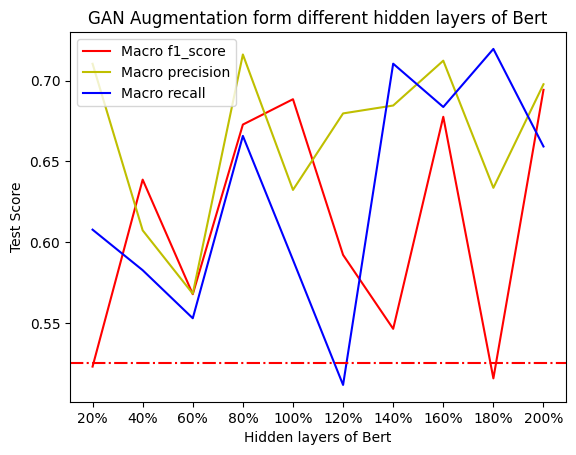

In [ ]:
x_label=[str(i*20)+"%" for i in range(1,11)]
import matplotlib.pyplot as plt
# plt.plot(ACCs, label="accuracy")
fig = plt.figure(edgecolor='k', frameon=True)
# fig.patch.set_facecolor('xkcd:blue')
plt.plot(tbk_f1, label="Macro f1_score",color='r')
plt.plot(gan_f1, label="Macro precision",color='y')
plt.plot(hybrid_f1, label="Macro recall",color='b')
plt.axhline(y = 0.525, color = 'r', linestyle = 'dashdot')
plt.xticks([i for i in range(10)],x_label)
plt.xlabel("Hidden layers of Bert")
plt.ylabel("Test Score")
plt.title("GAN Augmentation form different hidden layers of Bert")
plt.legend()
plt.show()